In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from dython import nominal

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
from xgboost import plot_importance

from utils import *
import math
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fatineboujnouni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")
train_data.head()

ad_batchId                             ad_taskId  \
0  fbad6cd7-28fd-4f4b-aaa6-a6b868948346  5b43fa5d-1366-458f-adca-d93c798d5218   
1  1d0a94b7-3ffd-424b-80e9-56628dae3dfe  704f1602-3806-41c2-bf31-f5e87dcdac7a   
2  12c1bf84-4d5f-48e1-b9bf-6b55d076846e  21629a4b-645e-46e2-b6c6-aa88a6d52311   
3  ff716a24-a089-4097-85b0-79c892a0bcd2  978c3ad4-150c-4eac-a91e-e61cbdb386a4   
4  9a3c9c1c-6966-4e2f-a2b8-9aaba4fc6223  a0b796f9-0e01-4ea2-a7c7-75d1754f5c8f   

                    ad_content_title  \
0                  Mercedes-Benz 190   
1  Решетка в бампер BMW E60 03-07 RH   
2  Помпа на Subaru Outback 2013-2015   
3                           Audi 100   
4          ВАЗ (Lada) 2108 (хэтчбек)   

                                     ad_content_body  ad_content_price_amount  \
0  Продается мерс, вложение по кузову, все вопрос...                 520000.0   
1  Решетка в бампер BMW E60 03-07 RH. \nДубликат....                   6000.0   
2  Помпа на Субару Аутбак 2013-2015 двигатель FB2...                    222.0   
3                            С продажей не тороплюсь                1000000.0   
4  Продаю ваз 2108, 91 года. машина на ходу\nНахо...                 270000.0   

  ad_content_price_currency ad_content_category_name  \
0                       KZT                Used cars   
1                       KZT      Sale of spare parts   
2                       KZT      Sale of spare parts   
3                       KZT                Used cars   
4                       KZT                Used cars   

       ad_content_createdAt       ad_content_updatedAt  \
0  2018-02-12T10:18:07.000Z  2018-02-12 10:19:47+00:00   
1  2018-02-11T12:19:18.000Z  2018-02-12 10:19:49+00:00   
2  2018-02-12T12:50:49.000Z  2018-02-12 12:54:35+00:00   
3  2018-02-12T12:51:41.000Z  2018-02-12 12:54:35+00:00   
4  2018-02-12T12:44:40.000Z  2018-02-12 12:54:38+00:00   

   ad_content_customerSpecific_version  ...  \
0                                   13  ...   
1                                    7  ...   
2                                   12  ...   
3                                    8  ...   
4                                   11  ...   

  ad_content_customerSpecific_wheelDiscType  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

  ad_content_customerSpecific_wheelSize  ad_content_customerSpecific_wheelPcd  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   
3                                   NaN                                   NaN   
4                                   NaN                                   NaN   

   ad_content_customerSpecific_autoMotoModel  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   ad_content_customerSpecific_autoMotoBody  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   ad_content_customerSpecific_autoCondition  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   ad_content_customerSpecific_wheelTireType  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                     

# I/-Exploring dataset

We first start exploring the dataset and its colmuns. 

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   ad_batchId                                  400000 non-null  object 
 1   ad_taskId                                   400000 non-null  object 
 2   ad_content_title                            400000 non-null  object 
 3   ad_content_body                             370131 non-null  object 
 4   ad_content_price_amount                     399851 non-null  float64
 5   ad_content_price_currency                   399851 non-null  object 
 6   ad_content_category_name                    400000 non-null  object 
 7   ad_content_createdAt                        400000 non-null  object 
 8   ad_content_updatedAt                        400000 non-null  object 
 9   ad_content_customerSpecific_version         400000 non-null  int64  
 

We see that a lot of columns suffers from missing data, however an important remark is that a lot of columns are category specific. We start by exploring columns with less missing data. 

### TARGET COLUMN 

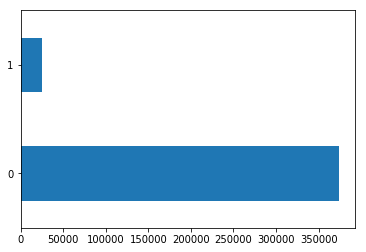

In [14]:
target_column = "ad_customerSpecific_moderationDecision"
train_data[target_column].value_counts().plot(kind='barh')

In [5]:
train_data[target_column].value_counts(normalize=True)*100

approved    93.6075
rejected     6.3925
Name: ad_customerSpecific_moderationDecision, dtype: float64

We also notive that the target classes are highly imbalanced. 94% of the samples belong to the positive class, and only 6% belong to the negative class. 

I encoded the minority class `Rejected` as the positive class, an `Approved` as the negative class. 

In [6]:
train_data[target_column] = train_data[target_column].apply(lambda x : 1 if x=="rejected" else 0)

### LOCATION COLUMNS 

In [7]:
location_columns = [col for col in train_data.columns if "location" in col]
location_columns

['ad_location_ipAddress',
 'ad_location_city',
 'ad_location_region',
 'ad_location_customerSpecific_regionList_id']

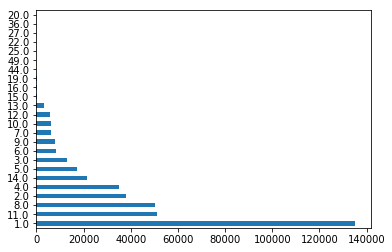

In [8]:
train_data["ad_location_customerSpecific_regionList_id"].value_counts()[:20].plot(kind="barh")

`ad_location_customerSpecific_regionList_id` is a categorical data. 

In [9]:
# Transform `ad_location_customerSpecific_regionList_id` to categorical data.
train_data["ad_location_customerSpecific_regionList_id"] = train_data["ad_location_customerSpecific_regionList_id"].astype('object')
test_data["ad_location_customerSpecific_regionList_id"] = test_data["ad_location_customerSpecific_regionList_id"].astype('object')

We compute the correlation between the variables : `ad_location_customerSpecific_regionList_id`, `ad_location_city`, `ad_location_region`, `ad_location_ipAddress`

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


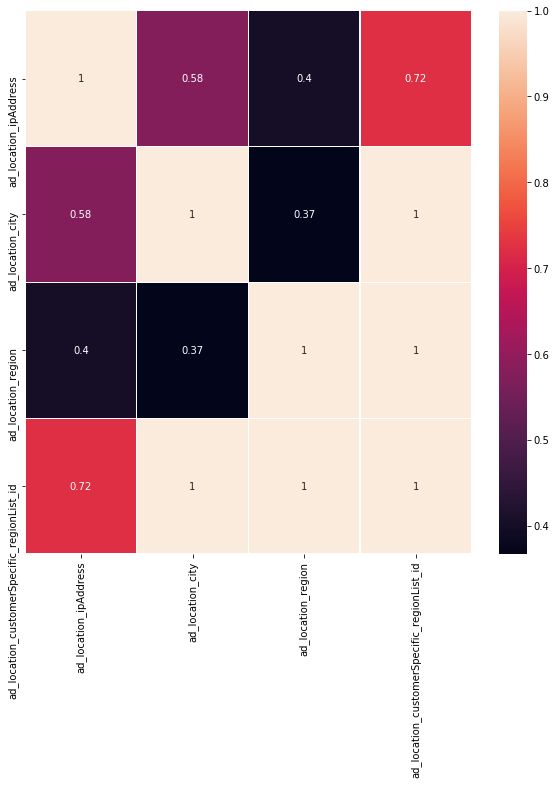

In [10]:
corr_matrix = nominal.associations(train_data[location_columns], nominal_columns=location_columns, plot=False, return_results=True , theils_u=True)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)

As `ad_location_customerSpecific_regionList_id`, `ad_location_city`, `ad_location_region`, `ad_location_ipAddress` are highly correlated. We keep just one of them : `ad_location_customerSpecific_regionList_id`

In [11]:
train_data.drop(columns=['ad_location_city','ad_location_region','ad_location_ipAddress'], inplace=True)
test_data.drop(columns=['ad_location_city','ad_location_region','ad_location_ipAddress'], inplace=True)

### PRICE CURRENCY COLUMNS

In [12]:
train_data["ad_content_price_currency"].value_counts()

KZT    399841
USD         8
RUB         2
Name: ad_content_price_currency, dtype: int64

In [13]:
test_data["ad_content_price_currency"].value_counts()

KZT    100190
USD         8
Name: ad_content_price_currency, dtype: int64

The majority of the currencies are in KZT. And only 10 prices are in different currencies. So it would be better of we convert all currencies to `KZT`

In [14]:
currency_exchange_dict = {"RUB_KZT" : 5.82, 
                         "USD_KZT": 399.63}

# USD to KZT 
train_data["ad_content_price_amount"] = train_data["ad_content_price_amount"]*currency_exchange_dict['USD_KZT']
train_data["ad_content_price_currency"] = "KZT"

test_data["ad_content_price_amount"] = test_data["ad_content_price_amount"]*currency_exchange_dict['USD_KZT']
test_data["ad_content_price_currency"] = "KZT"

# RUB to KZT 
train_data["ad_content_price_amount"] = train_data["ad_content_price_amount"]*currency_exchange_dict['RUB_KZT']
train_data["ad_content_price_currency"] = "KZT"

# `ad_content_price_currency` have only one value, it doesn't add any new information. It can be dropped.
train_data.drop(columns="ad_content_price_currency", inplace=True)
test_data.drop(columns="ad_content_price_currency", inplace=True)

### TIME COLUMNS 

We have 3 time columns.
I created 5 features using those 3 columns : 
    - Number of days between content creation and content update.
    - Number of days between specific customer registraction and content creation. 
    -  features that indicate whether a date is a weekend day or not.

In [15]:
time_columns = ['ad_content_createdAt','ad_content_updatedAt','ad_user_customerSpecific_registeredAt']

# Convert time columns to pandas datetime
for col in time_columns:
    train_data[col] = pd.to_datetime(train_data[col], utc=True)
    test_data[col] = pd.to_datetime(test_data[col], utc=True)

train_data['time_between_creation_update'] = (train_data['ad_content_updatedAt'] - train_data['ad_content_createdAt']).dt.days
train_data['time_between_registration_creation'] = (train_data['ad_content_createdAt'] - train_data['ad_user_customerSpecific_registeredAt'] ).dt.days
train_data['ad_content_createdAt_weekday'] = (train_data['ad_content_createdAt'].dt.dayofweek//5 == 1).astype(float)
train_data['ad_content_updatedAt_weekday'] = (train_data['ad_content_updatedAt'].dt.dayofweek//5 == 1).astype(float)
train_data['ad_user_customerSpecific_registeredAt_weekday'] = (train_data['ad_user_customerSpecific_registeredAt'].dt.dayofweek//5 == 1).astype(float)
train_data.drop(columns=time_columns, inplace=True)


test_data['time_between_creation_update'] = (test_data['ad_content_updatedAt'] - test_data['ad_content_createdAt']).dt.days
test_data['time_between_registration_creation'] = (test_data['ad_content_createdAt'] - test_data['ad_user_customerSpecific_registeredAt'] ).dt.days
test_data['ad_content_createdAt_weekday'] = (test_data['ad_content_createdAt'].dt.dayofweek//5 == 1).astype(float)
test_data['ad_content_updatedAt_weekday'] = (test_data['ad_content_updatedAt'].dt.dayofweek//5 == 1).astype(float)
test_data['ad_user_customerSpecific_registeredAt_weekday'] = (test_data['ad_user_customerSpecific_registeredAt'].dt.dayofweek//5 == 1).astype(float)
test_data.drop(columns=time_columns, inplace=True)

In [16]:
time_weekday_columns = [col for col in train_data.columns if "weekday" in col]
time_weekday_columns

['ad_content_createdAt_weekday',
 'ad_content_updatedAt_weekday',
 'ad_user_customerSpecific_registeredAt_weekday']

The `weekday` columns are categorical variables.

In [17]:
for col in time_weekday_columns:
    train_data[col] = train_data[col].astype('object')
    test_data[col] = test_data[col].astype('object')

### TEXT PREPROCESSING 

In [310]:
## Compute number of words in ad_content_title and ad_content_body
train_data['len_title_words'] = train_data["ad_content_title"].apply(lambda x : compute_words(str(x)))
train_data['len_body_content_words'] = train_data["ad_content_body"].apply(lambda x : compute_words(str((x))))
# Compute ratio between #title_words / #body_words
train_data['ratio_title_body_words'] = train_data['len_title_words'] / (train_data['len_body_content_words']+1)
# Compute number of different words and commun words 
train_data['len_commun_words_title_body']= train_data[['ad_content_title','ad_content_body']].apply(lambda x: len_commun_tokens(str(x[0]),str(x[1])) , axis=1)
train_data['len_different_words_title_body'] = train_data[['ad_content_title','ad_content_body']].apply(lambda x: len_different_tokens(str(x[0]),str(x[1])) , axis=1)
train_data['ratio_commun_different_words'] = train_data['len_commun_words_title_body'] / (train_data['len_different_words_title_body']+1)

In [311]:
## Compute number of words in ad_content_title and ad_content_body
test_data['len_title_words'] = test_data["ad_content_title"].apply(lambda x : compute_words(str(x)))
test_data['len_body_content_words'] = test_data["ad_content_body"].apply(lambda x : compute_words(str((x))))
# Compute ratio between #title_words / #body_words
test_data['ratio_title_body_words'] = test_data['len_title_words'] / (test_data['len_body_content_words']+1)
# Compute number of different words and commun words 
test_data['len_commun_words_title_body']= test_data[['ad_content_title','ad_content_body']].apply(lambda x: len_commun_tokens(str(x[0]),str(x[1])) , axis=1)
test_data['len_different_words_title_body'] = test_data[['ad_content_title','ad_content_body']].apply(lambda x: len_different_tokens(str(x[0]),str(x[1])) , axis=1)
test_data['ratio_commun_different_words'] = test_data['len_commun_words_title_body'] / (test_data['len_different_words_title_body']+1)

In [312]:
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

### CATEGORICAL VARIABLES PREPROCESSING 

In [313]:
categorical_columns = train_data.drop(columns=target_column).select_dtypes(include=['object']).columns

In [314]:
for col in categorical_columns:
    print("#"*50)
    print(col)
    print("#"*50)
    print(train_data[col].value_counts())

##################################################
ad_batchId
##################################################
ab5bbd2b-991a-4630-a291-6c957589ec8c    1
a4518ac0-1a5e-4c23-9704-c742598f0cff    1
b3fda64d-aa73-42f2-b270-1795baefe63b    1
adb5c83f-d2e1-4d40-a392-d2ba465d3744    1
cf36625e-fa8a-4e37-82e8-50798eacf4d1    1
                                       ..
334b7c7b-03cf-4c07-917e-6dae881a90ac    1
db70f714-2f76-482d-8ccd-acf75640a52b    1
d31f9643-92c7-404e-a16b-29c781dbde72    1
95063597-be9e-424e-bdc1-978ba2a95d3e    1
c60ea286-d8c6-494d-b64b-e502ace99547    1
Name: ad_batchId, Length: 400000, dtype: int64
##################################################
ad_taskId
##################################################
576aaddf-d725-43a0-8886-937926bdb413    1
99255040-04e6-494e-b855-a3f9c1819558    1
6f72483d-8f8d-448a-8d99-58131350bd64    1
67330054-c76c-401b-b9ee-cc315e396d09    1
418928d9-cd58-4fce-817a-24fcb3651116    1
                                       ..
e5af6017-01c0-

1.0     31622
2.0     26081
6.0     21799
7.0     13275
5.0     12002
3.0     10622
21.0     4117
4.0      4054
22.0     3473
8.0      3170
13.0     1927
12.0     1811
11.0     1605
14.0     1195
18.0      525
23.0      499
15.0      401
9.0       334
17.0      330
16.0      264
20.0       41
Name: ad_content_customerSpecific_autoColor, dtype: int64
##################################################
ad_content_customerSpecific_autoCustom
##################################################
2.0    143065
1.0      8809
Name: ad_content_customerSpecific_autoCustom, dtype: int64
##################################################
ad_content_customerSpecific_autoEmergency
##################################################
1.0    147461
3.0      2462
2.0      1954
Name: ad_content_customerSpecific_autoEmergency, dtype: int64
##################################################
ad_content_customerSpecific_autoCarGrbody
##################################################
1.0    112780
2.0     27136


I think the column `ad_content_customerSpecific_autoCarMm` contains a vector of measures. 
Maybe it would be good to preprocess this column and transform it to 3 numerical columns that contain the measures.

We can also preprocess `ad_content_customerSpecific_wheelPcd`... But I'll leave that for later. 

In [325]:
def str_to_list(s):
    if pd.isna(s):
        return [np.nan]
    s = s[1:-1]
    s = s.split(',')
    if len(s) > 3:
        s = s[:1]
    s = [int(e.strip()[1:-1]) for e in s]
    return s


def preprocess_autoCarMm(df):
    df["ad_content_customerSpecific_autoCarMm"] = df["ad_content_customerSpecific_autoCarMm"].apply(str_to_list)
    autoCarMm_vector = df["ad_content_customerSpecific_autoCarMm"]
    df['ad_content_customerSpecific_autoCarMm_0'] = df["ad_content_customerSpecific_autoCarMm"].apply(lambda x : x[0])
    df['ad_content_customerSpecific_autoCarMm_1'] = df["ad_content_customerSpecific_autoCarMm"].apply(lambda x : x[1] if len(x)>1 else np.nan)
    df['ad_content_customerSpecific_autoCarMm_2'] = df["ad_content_customerSpecific_autoCarMm"].apply(lambda x : x[2] if len(x)==3 else np.nan)
    df.drop(columns='ad_content_customerSpecific_autoCarMm', inplace=True)

In [ ]:
preprocess_autoCarMm(train_data)
preprocess_autoCarMm(test_data)

### NUMERICAL VARIABLES PREPROCESSING 

In [ ]:
numerical_columns = train_data.select_dtypes(exclude=['object']).columns
for col in numerical_columns:
    print("#"*50)
    print(col)
    print("#"*50)
    print(train_data[col].value_counts())

Transform `ad_content_customerSpecific_version` to categorical data.

In [ ]:
bins_version = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, np.inf]
names_version = [ '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '14+']

train_data['ad_content_customerSpecific_version_range'] = pd.cut(train_data['ad_content_customerSpecific_version'], bins_version, labels=names_version)
test_data['ad_content_customerSpecific_version_range'] = pd.cut(test_data['ad_content_customerSpecific_version'], bins_version, labels=names_version)

In [ ]:
train_data.drop(columns='ad_content_customerSpecific_version', inplace=True)
test_data.drop(columns='ad_content_customerSpecific_version', inplace=True)

The columns `ad_content_customerSpecific_autoCarBody`, `ad_content_customerSpecific_year`,`ad_content_customerSpecific_autoCarTransm`, `ad_content_customerSpecific_autoColor`, `ad_content_customerSpecific_autoEmergency`, `ad_content_customerSpecific_autoCarGrbody`, `ad_content_customerSpecific_carDwheel`, `ad_content_customerSpecific_wheelDiscType`, `ad_content_customerSpecific_autoMotoBody`, `ad_content_customerSpecific_autoCondition`, `ad_content_customerSpecific_wheelTireType`, `ad_content_customerSpecific_autoCarOrder`, `ad_content_customerSpecific_autoCustom` and `ad_content_customerSpecific_spareCondition` are categorical. 

In [316]:
for col in ["ad_content_customerSpecific_autoCarBody","ad_content_customerSpecific_year",
            "ad_content_customerSpecific_autoCarTransm","ad_content_customerSpecific_autoColor",
            "ad_content_customerSpecific_autoEmergency","ad_content_customerSpecific_autoCarGrbody",
            "ad_content_customerSpecific_carDwheel", "ad_content_customerSpecific_wheelDiscType", 
            "ad_content_customerSpecific_autoMotoBody", "ad_content_customerSpecific_autoCondition",
            "ad_content_customerSpecific_wheelTireType", "ad_content_customerSpecific_autoCarOrder",
            "ad_content_customerSpecific_autoCustom","ad_content_customerSpecific_spareCondition"]:
    train_data[col] = train_data[col].astype('object')
    test_data[col] = test_data[col].astype('object')

In [317]:
numerical_columns = train_data.select_dtypes(exclude=['object']).columns
numerical_columns

Index(['ad_content_price_amount', 'ad_content_customerSpecific_autoCarVolume',
       'ad_content_customerSpecific_wheelWidth',
       'ad_content_customerSpecific_wheelHeight',
       'ad_customerSpecific_moderationDecision',
       'time_between_creation_update', 'time_between_registration_creation',
       'len_title_words', 'len_body_content_words', 'ratio_title_body_words',
       'len_commun_words_title_body', 'len_different_words_title_body',
       'ad_content_customerSpecific_autoCarMm_0',
       'ad_content_customerSpecific_autoCarMm_1',
       'ad_content_customerSpecific_autoCarMm_2',
       'ad_content_customerSpecific_version_range',
       'ratio_commun_different_words'],
      dtype='object')

### SPLIT DATA INTO CATEGORIES 

As a lot of columns are category specific, we should then split our dataset by categories. 

In [84]:
categories = set(train_data.ad_content_category_name)

categories

{'Sale of spare parts',
 'Tires',
 'Two-wheeled motor vehicles',
 'Used cars',
 'Wheel disks'}

5 Categories are present in our dataset, we will build a different model for each of them.

In [85]:
train_data_by_category = {}
test_data_by_category = {}

for category in set(train_data.ad_content_category_name):
    train_data_by_category[category] =\
     train_data[train_data.ad_content_category_name
                == category].drop("ad_content_category_name", axis=1)

    test_data_by_category[category] =\
     test_data[test_data.ad_content_category_name
                == category].drop("ad_content_category_name", axis=1)
            

By spltting the data set by categoy we see that we got rid of missing points, we almost have no missing data now. We still need a preporcessing step to get rid of columns with no data in each category:

In [86]:
for category in categories:
    train_data_by_category[category] =\
     train_data_by_category[category].dropna(axis=1, how="all")

    test_data_by_category[category] =\
     test_data_by_category[category].dropna(axis=1, how="all")


In [87]:
for category in categories:
    print("Category: {}".format(category))
    print("Train")
    print(train_data_by_category[category].info())
    print("Test")
    print(test_data_by_category[category].info())
    print("#"*20)

Category: Tires
Train
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13313 entries, 188 to 399981
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     13313 non-null  object 
 1   ad_taskId                                      13313 non-null  object 
 2   ad_content_title                               13313 non-null  object 
 3   ad_content_body                                12784 non-null  object 
 4   ad_content_price_amount                        13303 non-null  float64
 5   ad_content_customerSpecific_device             13313 non-null  object 
 6   ad_content_customerSpecific_autoCarOrder       13303 non-null  float64
 7   ad_location_customerSpecific_regionList_id     13303 non-null  float64
 8   ad_content_customerSpecific_spareCondition     13303 non-null  float64
 9   ad_content_customerSpecif

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151878 entries, 0 to 399996
Data columns (total 32 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   ad_batchId                                     151878 non-null  object 
 1   ad_taskId                                      151878 non-null  object 
 2   ad_content_title                               151878 non-null  object 
 3   ad_content_body                                124391 non-null  object 
 4   ad_content_price_amount                        151871 non-null  float64
 5   ad_content_customerSpecific_device             151878 non-null  object 
 6   ad_content_customerSpecific_autoCarBody        151876 non-null  float64
 7   ad_content_customerSpecific_autoCarOrder       151872 non-null  float64
 8   ad_content_customerSpecific_year               151877 non-null  float64
 9   ad_content_customerSpecific_autoCarVo

**Conlusion**: The dataset is in fact the concatenation of four datasets, each of them for a specific catgeory. Only two varibales seems to suffer from high missing data: `ad_content_customerSpecific_autoRun` and  `ad_content_customerSpecific_autoColorM`. Those variables are going to be droped.

In [ ]:
train_data.drop(columns=["ad_content_customerSpecific_autoRun","ad_content_customerSpecific_autoColorM"], inplace=True)
test_data.drop(columns=["ad_content_customerSpecific_autoRun","ad_content_customerSpecific_autoColorM"], inplace=True)

# II/- EDA & CLASSIFICATION MODEL FOR EACH CATEGORY

We will do a specific EDA and model for each sub dataset (i.e., each category)

## 1) Sale of spare parts

### A - EDA

In [1134]:
category = "Sale of spare parts"
current_data = train_data_by_category[category].copy()
current_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223615 entries, 1 to 399999
Data columns (total 25 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   ad_batchId                                     223615 non-null  object 
 1   ad_taskId                                      223615 non-null  object 
 2   ad_content_title                               223615 non-null  object 
 3   ad_content_body                                222393 non-null  object 
 4   ad_content_price_amount                        223575 non-null  float64
 5   ad_content_customerSpecific_device             223615 non-null  object 
 6   ad_content_customerSpecific_autoCarOrder       222757 non-null  float64
 7   ad_location_customerSpecific_regionList_id     223587 non-null  float64
 8   ad_content_customerSpecific_spareCondition     223586 non-null  float64
 9   ad_customerSpecific_moderationDecisio

In [1135]:
current_data.isna().sum()

ad_batchId                                            0
ad_taskId                                             0
ad_content_title                                      0
ad_content_body                                    1222
ad_content_price_amount                              40
ad_content_customerSpecific_device                    0
ad_content_customerSpecific_autoCarOrder            858
ad_location_customerSpecific_regionList_id           28
ad_content_customerSpecific_spareCondition           29
ad_customerSpecific_moderationDecision                0
time_between_creation_update                          0
time_between_registration_creation                 1289
ad_content_createdAt_weekday                          0
ad_content_updatedAt_weekday                          0
ad_user_customerSpecific_registeredAt_weekday         0
len_title_words                                       0
len_body_content_words                                0
ratio_title_body_words                          

In [1136]:
current_test_data = test_data_by_category[category].copy()
current_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49027 entries, 6 to 100217
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     49027 non-null  object 
 1   ad_taskId                                      49027 non-null  object 
 2   ad_content_title                               49027 non-null  object 
 3   ad_content_body                                48685 non-null  object 
 4   ad_content_price_amount                        49026 non-null  float64
 5   ad_content_customerSpecific_device             49027 non-null  object 
 6   ad_content_customerSpecific_autoCarOrder       48736 non-null  float64
 7   ad_location_customerSpecific_regionList_id     49026 non-null  float64
 8   ad_content_customerSpecific_spareCondition     49026 non-null  float64
 9   time_between_creation_update                   49

In [1137]:
current_test_data.isna().sum()

ad_batchId                                           0
ad_taskId                                            0
ad_content_title                                     0
ad_content_body                                    342
ad_content_price_amount                              1
ad_content_customerSpecific_device                   0
ad_content_customerSpecific_autoCarOrder           291
ad_location_customerSpecific_regionList_id           1
ad_content_customerSpecific_spareCondition           1
time_between_creation_update                         0
time_between_registration_creation                 393
ad_content_createdAt_weekday                         0
ad_content_updatedAt_weekday                         0
ad_user_customerSpecific_registeredAt_weekday        0
len_title_words                                      0
len_body_content_words                               0
ratio_title_body_words                               0
len_commun_words_title_body                          0
len_differ

#### PLOT THE DISTRIBUTION OF NUMERICAL DATA IN EACH CLASS

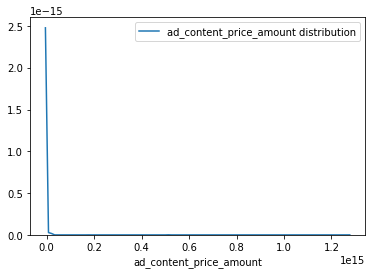

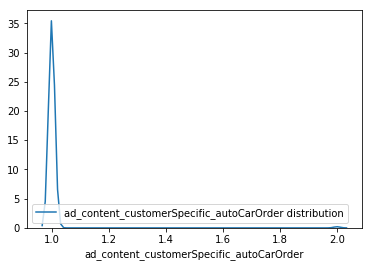

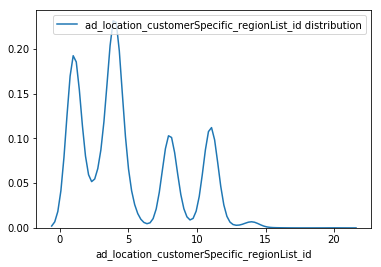

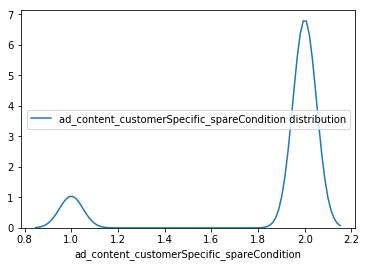

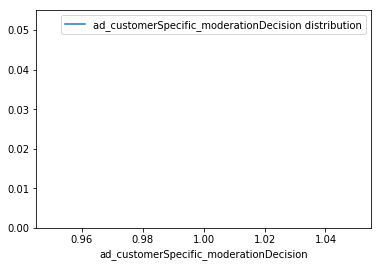

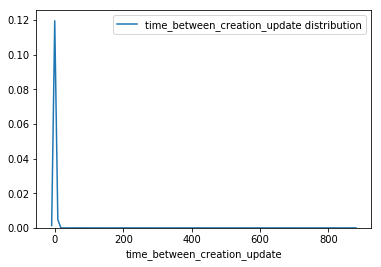

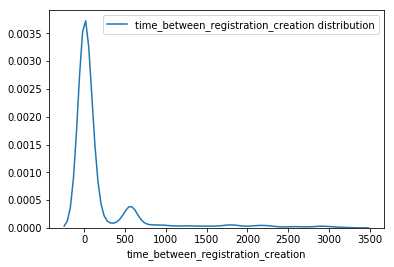

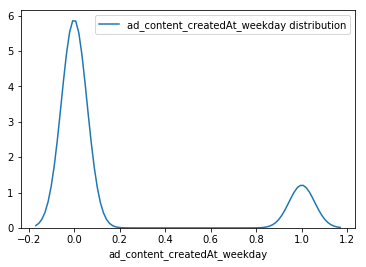

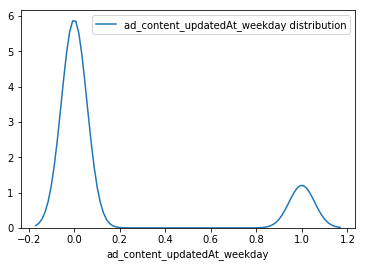

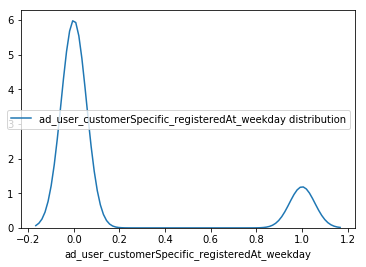

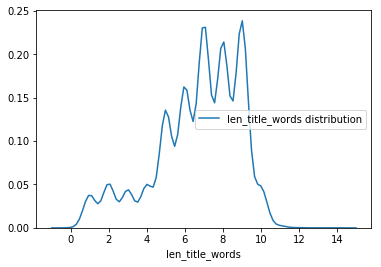

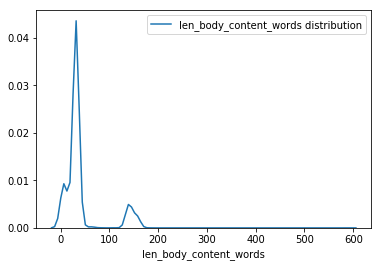

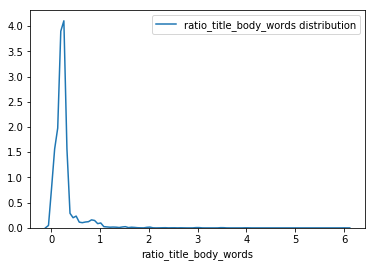

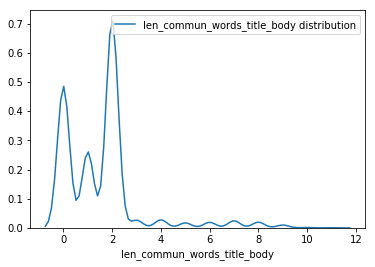

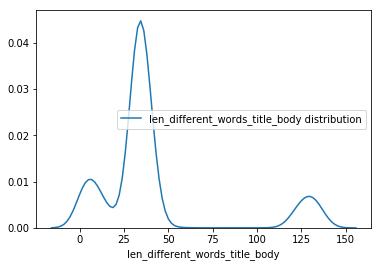

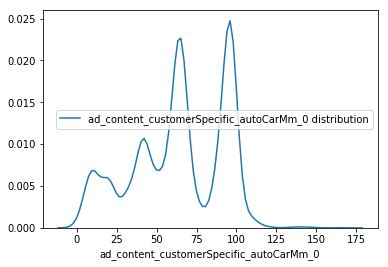

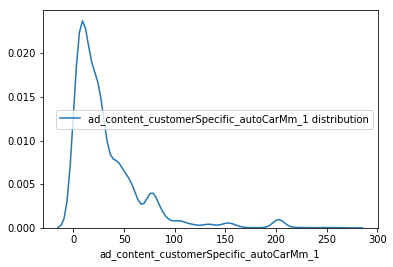

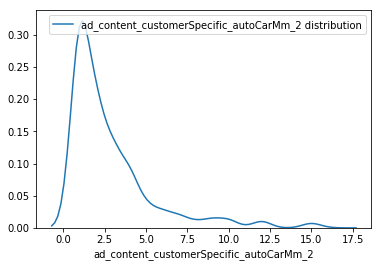

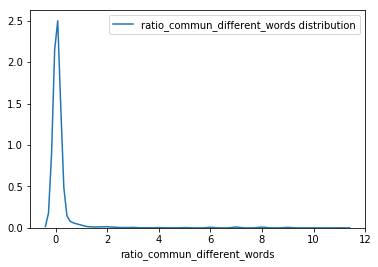

In [1138]:
## CLASS REJECTED
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==1][col], hist=False, label=col+" distribution")

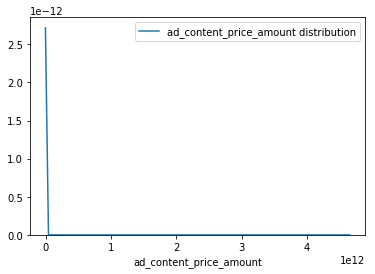

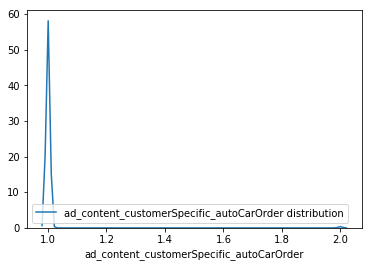

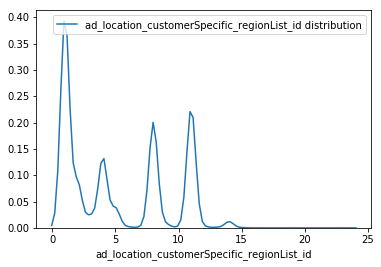

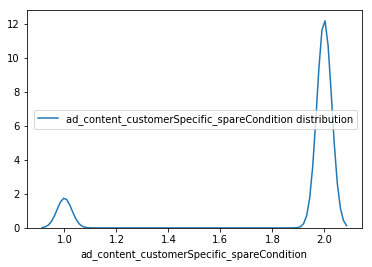

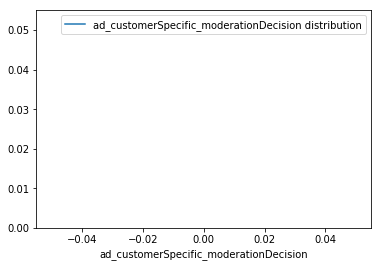

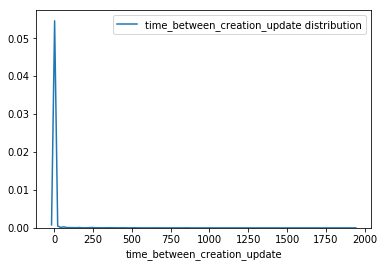

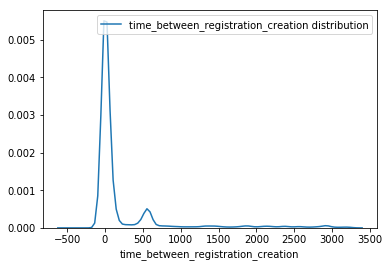

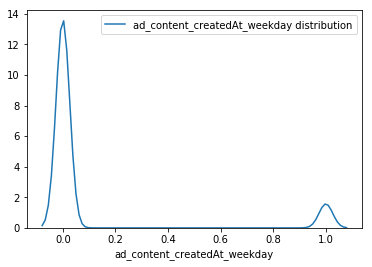

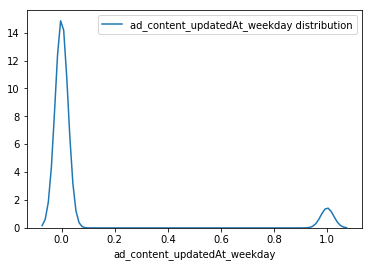

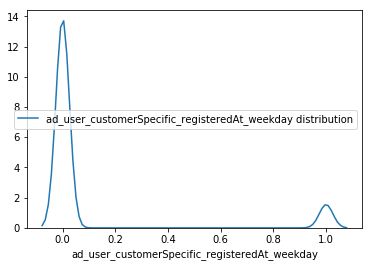

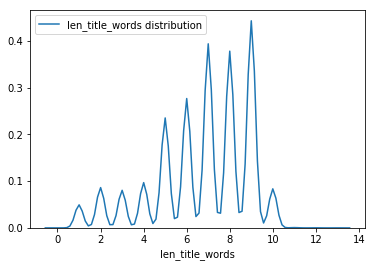

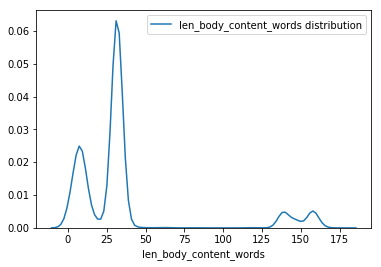

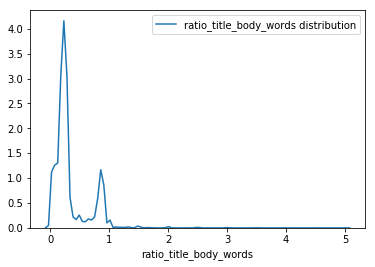

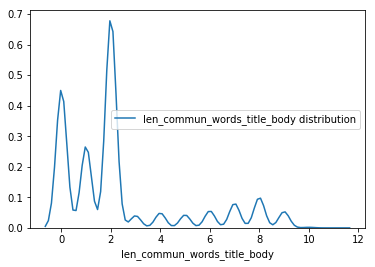

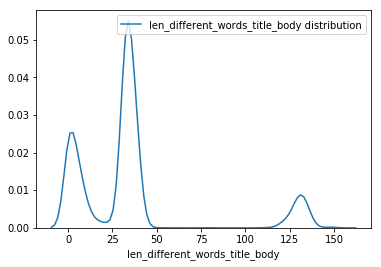

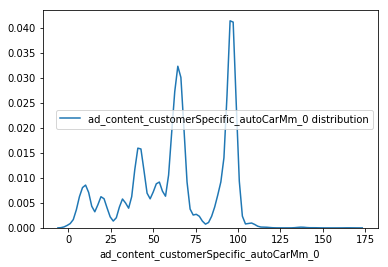

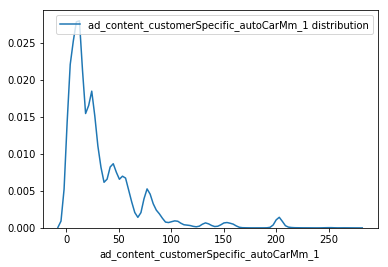

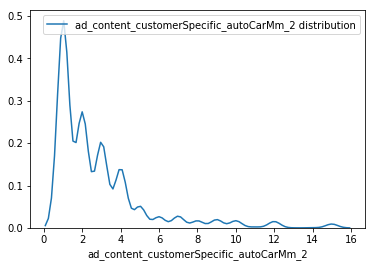

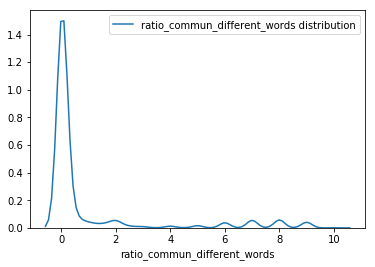

In [1139]:
## CLASS APPROVED 
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==0][col], hist=False, label=col+" distribution")

### B - DATA PREPATATION 

I dropped the columns that have similar distributions in the positive and negative class.

In [725]:
columns_to_drop = ['ad_batchId', 'ad_taskId','ad_content_title', 'ad_content_body', 'ad_content_customerSpecific_spareCondition','ad_content_customerSpecific_autoCarMm_2','ad_content_customerSpecific_autoCarOrder', 'len_title_words','len_body_content_words','len_commun_words_title_body','len_different_words_title_body']
current_data.drop(columns=columns_to_drop, inplace=True)
current_test_data.drop(columns=columns_to_drop, inplace=True)

In [726]:
numerical_columns = current_data.select_dtypes(include=[np.number]).columns
categorical_columns = current_data.drop(columns=target_column).select_dtypes(exclude=[np.number]).columns

In [727]:
## ENCODE CATEGORICAL VARIABLES 
current_data_features = current_data.drop(columns=target_column)
current_data_target = current_data[target_column]

current_data_features= pd.get_dummies(data=current_data_features, columns=categorical_columns)
current_test_data = pd.get_dummies(data=current_test_data, columns=categorical_columns)

current_data_features, current_test_data = current_data_features.align(current_test_data, join='left', axis=1)

## SPLIT DATA INTO TRAIN AND VALIDATION SETS 
X_train, X_val, y_train, y_val = train_test_split(current_data_features, current_data_target,
                                                    stratify=current_data_target, 
                                                    test_size=0.20)

In [728]:
imb_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
print(f"Classes are imbalanced with a ratio of {np.round(imb_weight*100, 2)}% of 0/1")

Classes are imbalanced with a ratio of 1565.04% of 0/1


### C - BUILD CLASSIFICATION MODEL

In [729]:
model = xgb.XGBClassifier(n_estimators=500, max_depth=7,
                          scale_pos_weight= imb_weight,
                          max_delta_step= 1.8,
                         random_state=42, 
                         learning_rate=0.1,
                          min_child_weight = 5 ,n_jobs=4)

model.fit(X_train,y_train)

XGBClassifier(max_delta_step=1.8, max_depth=7, min_child_weight=5,
              n_estimators=500, n_jobs=4, random_state=42,
              scale_pos_weight=15.650409530900967)

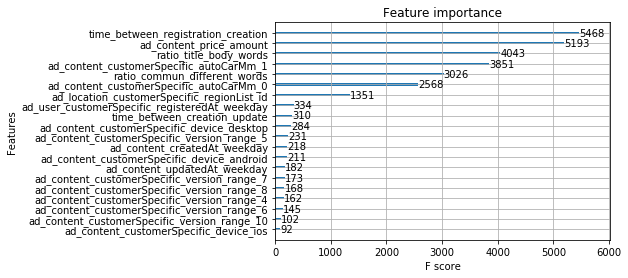

In [730]:
plot_importance(model, max_num_features=20)

### D - MODEL VALIDATION 

In [731]:
y_pred = model.predict_proba(X_val)

ROC AUC=0.904


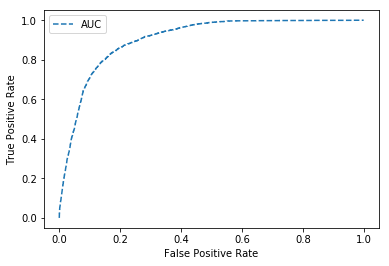

In [732]:
# calculate scores
auc = roc_auc_score(y_val, y_pred[:, 1])

# summarize scores
print('ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

In [733]:
for thrs in np.arange(0.1, 0.9, 0.05):
    y_pred_cm = (y_pred[:,1] > thrs)*1
    print("threshold : ", round(thrs,2), ", F1 score : ", f1_score(y_val,y_pred_cm), ", % of predicted positifs : ", np.mean(y_pred_cm==1))
    print("Recall : ", recall_score(y_val, y_pred_cm), ", Precision : ", precision_score(y_val, y_pred_cm))
    print("#"*50)

threshold :  0.1 , F1 score :  0.23607366448841563 , % of predicted positifs :  0.429242224358831
Recall :  0.9616530156366344 , Precision :  0.13455227379278012
##################################################
threshold :  0.15 , F1 score :  0.2643472776960269 , % of predicted positifs :  0.3654048252576974
Recall :  0.9363365599404319 , Precision :  0.15389793170970506
##################################################
threshold :  0.2 , F1 score :  0.29222056631892696 , % of predicted positifs :  0.315028061623773
Recall :  0.9125093075204765 , Precision :  0.17396550500390376
##################################################
threshold :  0.25 , F1 score :  0.31386957092245116 , % of predicted positifs :  0.2807503968875075
Recall :  0.8905435591958303 , Precision :  0.1905065307422746
##################################################
threshold :  0.3 , F1 score :  0.33281404900155787 , % of predicted positifs :  0.25570735415781587
Recall :  0.8749069247952346 , Precision :  0.

[[35239  6798]
 [  480  2206]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     42037
           1       0.25      0.82      0.38      2686

    accuracy                           0.84     44723
   macro avg       0.62      0.83      0.64     44723
weighted avg       0.94      0.84      0.87     44723



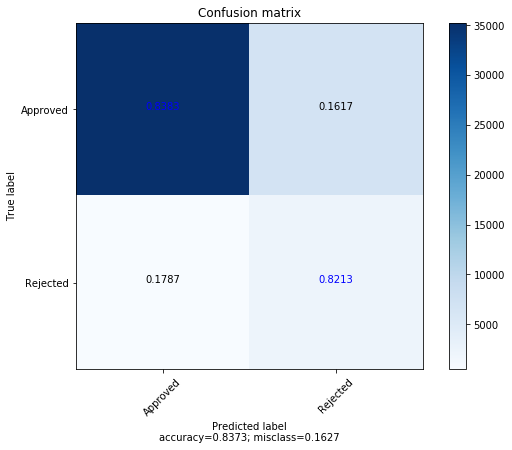

In [734]:
thrs = 0.45
y_pred_cm = (y_pred[:, 1] > thrs)*1
print(confusion_matrix(y_val, y_pred_cm))

print(classification_report(y_val, y_pred_cm))

plot_confusion(confusion_matrix(y_val, y_pred_cm),
              ['Approved', 'Rejected'],
              title='Confusion matrix',
              cmap=None,
              normalize=True)

In this problem, we want to detect instances of the minority class `rejected`. So I'm concerned more with having a good recall than precision.

The recall of the positive class `rejected`is high, but the precision is still low. 
That means the class is well detected but the model also include points of other class in it.

In the context of detecting `Rejected` ads, I believe that it makes more sence to have a manual reviewer find that the ad is `Approved`, but it is much harder to identify a `Rejected` ad that was never even flagged as such.

### E - Model Predictions 

In [735]:
y_test_pred = model.predict_proba(current_test_data)

y_test = (y_test_pred[:, 1] > thrs)*1
y_test = ["rejected" if x==1 else "approved" for x in y_test]

test_data_by_category[category][target_column] = y_test

In [736]:
Counter(y_test)

Counter({'rejected': 11479, 'approved': 37548})

## 2) Tires

### A - EDA

In [1126]:
category = "Tires"
current_data = train_data_by_category[category].copy()

current_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13313 entries, 188 to 399981
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     13313 non-null  object 
 1   ad_taskId                                      13313 non-null  object 
 2   ad_content_title                               13313 non-null  object 
 3   ad_content_body                                12784 non-null  object 
 4   ad_content_price_amount                        13303 non-null  float64
 5   ad_content_customerSpecific_device             13313 non-null  object 
 6   ad_content_customerSpecific_autoCarOrder       13303 non-null  float64
 7   ad_location_customerSpecific_regionList_id     13303 non-null  float64
 8   ad_content_customerSpecific_spareCondition     13303 non-null  float64
 9   ad_content_customerSpecific_wheelSize          

In [1127]:
current_data.isna().sum()

ad_batchId                                         0
ad_taskId                                          0
ad_content_title                                   0
ad_content_body                                  529
ad_content_price_amount                           10
ad_content_customerSpecific_device                 0
ad_content_customerSpecific_autoCarOrder          10
ad_location_customerSpecific_regionList_id        10
ad_content_customerSpecific_spareCondition        10
ad_content_customerSpecific_wheelSize             10
ad_content_customerSpecific_wheelTireType         10
ad_content_customerSpecific_wheelWidth            10
ad_content_customerSpecific_wheelHeight           10
ad_customerSpecific_moderationDecision             0
time_between_creation_update                       0
time_between_registration_creation               254
ad_content_createdAt_weekday                       0
ad_content_updatedAt_weekday                       0
ad_user_customerSpecific_registeredAt_weekday 

In [1128]:
current_test_data = test_data_by_category[category].copy()
current_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182 entries, 169 to 100110
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     4182 non-null   object 
 1   ad_taskId                                      4182 non-null   object 
 2   ad_content_title                               4182 non-null   object 
 3   ad_content_body                                4062 non-null   object 
 4   ad_content_price_amount                        4181 non-null   float64
 5   ad_content_customerSpecific_device             4182 non-null   object 
 6   ad_content_customerSpecific_autoCarOrder       4182 non-null   float64
 7   ad_location_customerSpecific_regionList_id     4182 non-null   float64
 8   ad_content_customerSpecific_spareCondition     4182 non-null   float64
 9   ad_content_customerSpecific_wheelSize          4

In [1129]:
current_test_data.isna().sum()

ad_batchId                                         0
ad_taskId                                          0
ad_content_title                                   0
ad_content_body                                  120
ad_content_price_amount                            1
ad_content_customerSpecific_device                 0
ad_content_customerSpecific_autoCarOrder           0
ad_location_customerSpecific_regionList_id         0
ad_content_customerSpecific_spareCondition         0
ad_content_customerSpecific_wheelSize              0
ad_content_customerSpecific_wheelTireType          0
ad_content_customerSpecific_wheelWidth             0
ad_content_customerSpecific_wheelHeight            0
time_between_creation_update                       0
time_between_registration_creation               110
ad_content_createdAt_weekday                       0
ad_content_updatedAt_weekday                       0
ad_user_customerSpecific_registeredAt_weekday      0
len_title_words                               

In [1130]:
#current_data["time_between_creation_update"] = current_data["time_between_creation_update"]/12
#current_data["time_between_registration_creation"] = current_data["time_between_registration_creation"]/12

#### PLOT THE DISTRIBUTION OF NUMERICAL DATA IN EACH CLASS

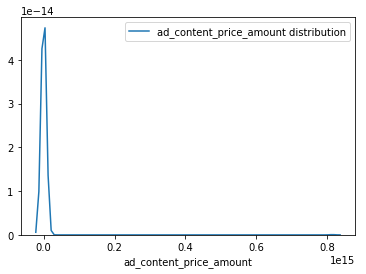

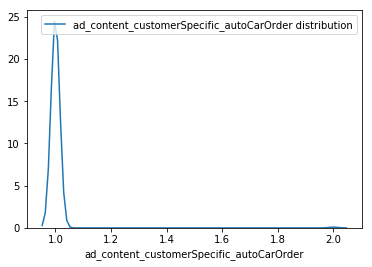

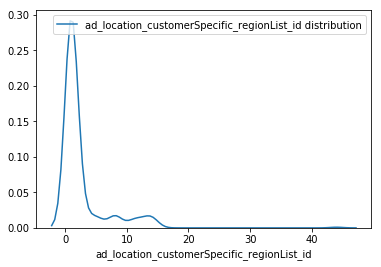

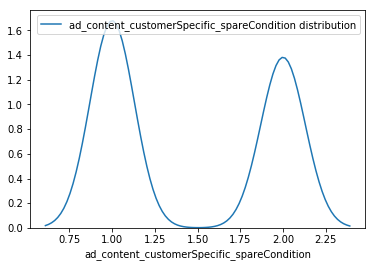

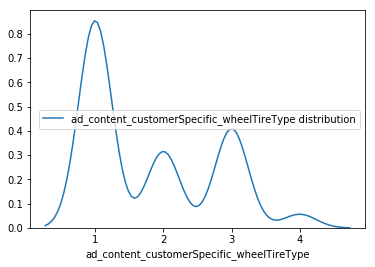

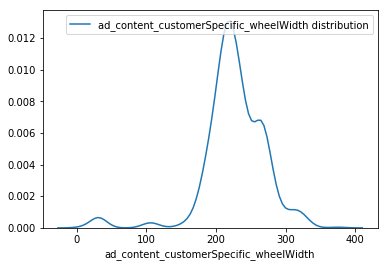

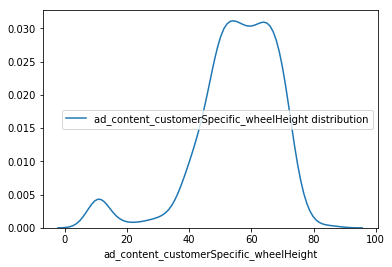

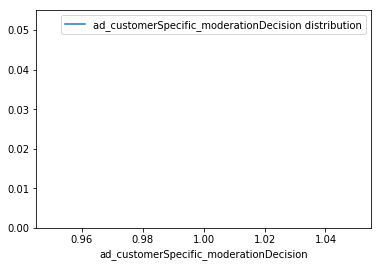

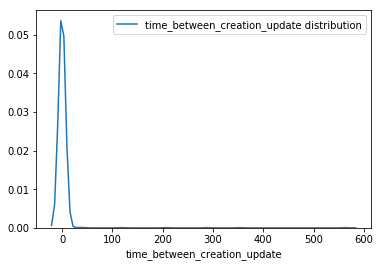

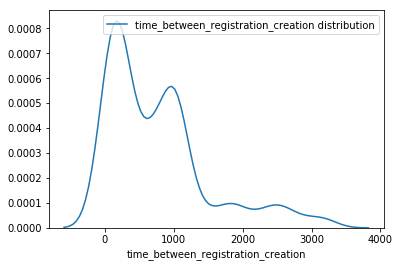

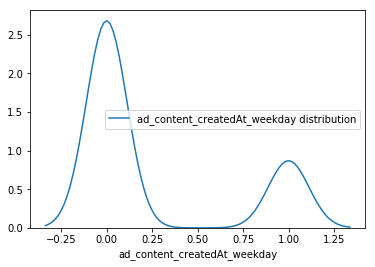

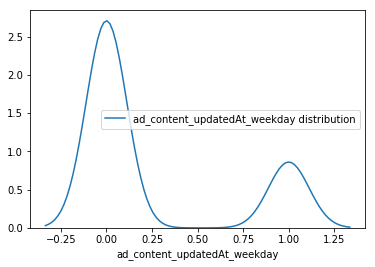

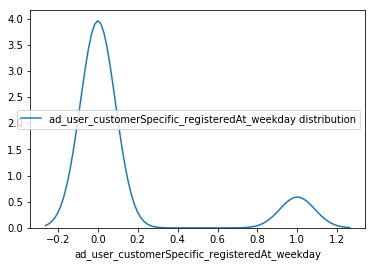

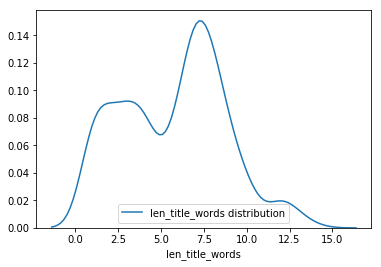

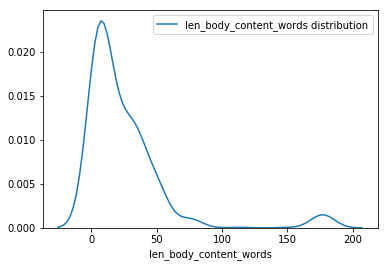

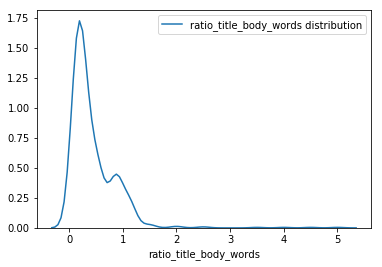

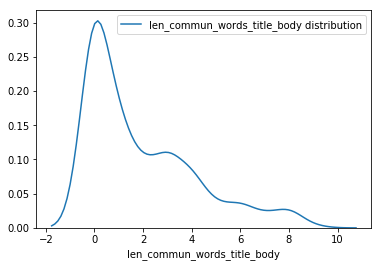

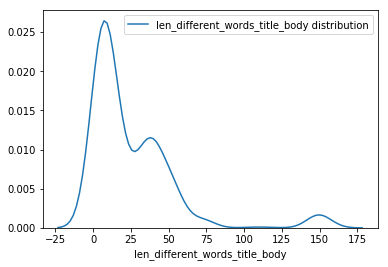

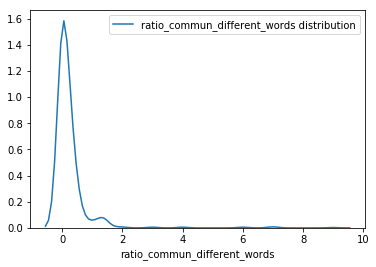

In [1131]:
## CLASS REJECTED
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==1][col], hist=False, label=col+" distribution")

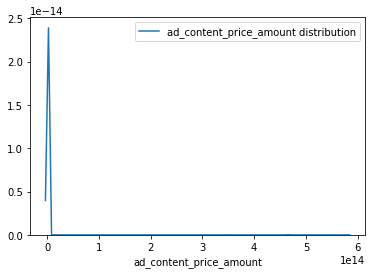

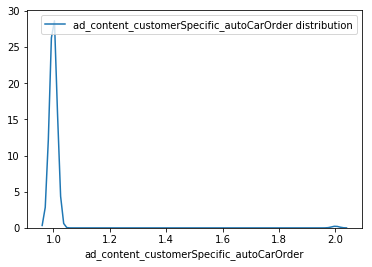

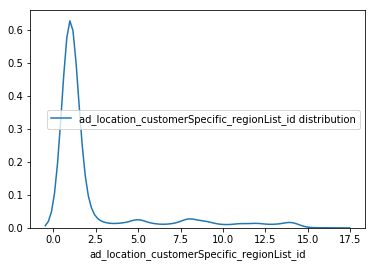

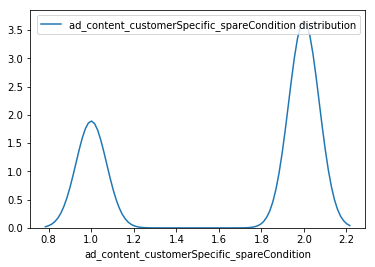

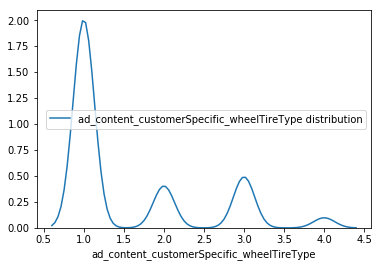

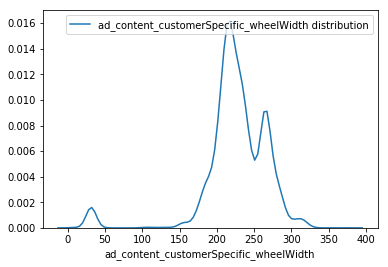

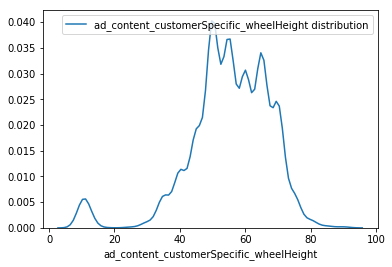

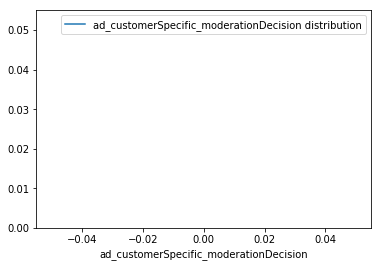

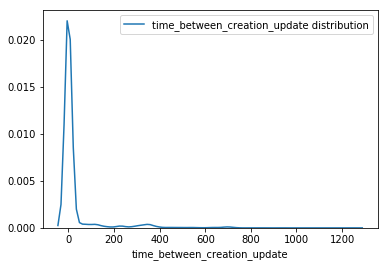

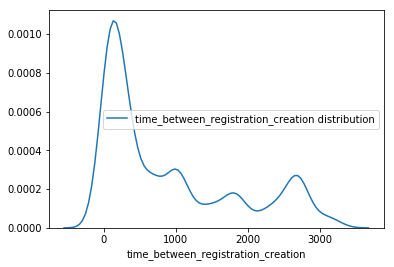

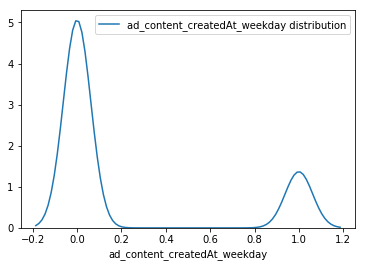

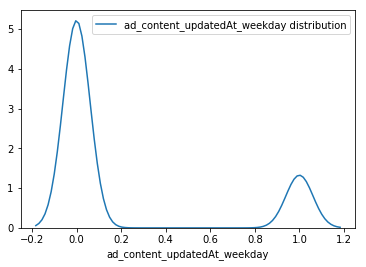

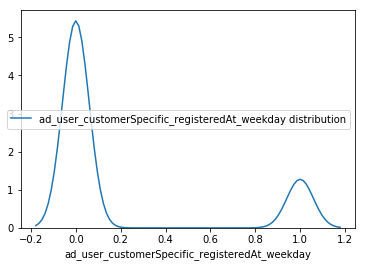

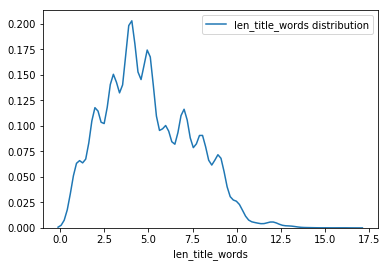

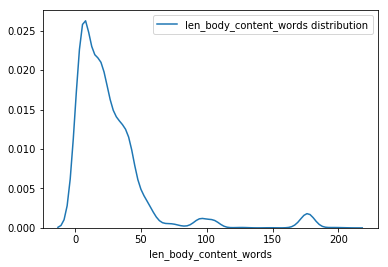

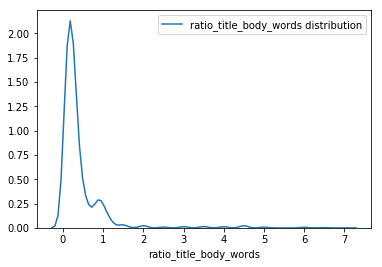

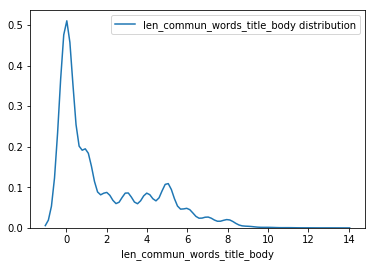

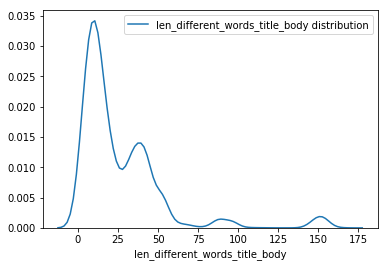

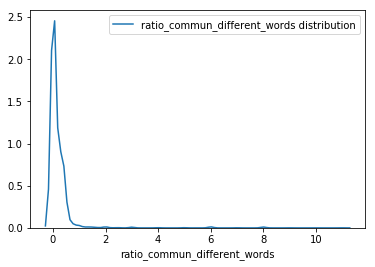

In [1133]:
## CLASS APPROVED 
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==0][col], hist=False, label=col+" distribution")

### B - DATA PREPARATION 

In [835]:
current_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13313 entries, 188 to 399981
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     13313 non-null  object 
 1   ad_taskId                                      13313 non-null  object 
 2   ad_content_title                               13313 non-null  object 
 3   ad_content_body                                12784 non-null  object 
 4   ad_content_price_amount                        13303 non-null  float64
 5   ad_content_customerSpecific_device             13313 non-null  object 
 6   ad_content_customerSpecific_autoCarOrder       13303 non-null  float64
 7   ad_location_customerSpecific_regionList_id     13303 non-null  float64
 8   ad_content_customerSpecific_spareCondition     13303 non-null  float64
 9   ad_content_customerSpecific_wheelSize          

In [836]:
columns_to_drop = ['ad_batchId', 'ad_taskId','ad_content_title', 'ad_content_body','len_commun_words_title_body','len_different_words_title_body']
current_data.drop(columns=columns_to_drop, inplace=True)
current_test_data.drop(columns=columns_to_drop, inplace=True)

In [837]:
numerical_columns = current_data.select_dtypes(include=[np.number]).columns
categorical_columns = current_data.drop(columns=target_column).select_dtypes(exclude=[np.number]).columns

## ENCODE CATEGORICAL VARIABLES 
current_data_features = current_data.drop(columns=target_column)
current_data_target = current_data[target_column]

current_data_features= pd.get_dummies(data=current_data_features, columns=categorical_columns)
current_test_data = pd.get_dummies(data=current_test_data, columns=categorical_columns)

current_data_features, current_test_data = current_data_features.align(current_test_data, join='left', axis=1)

## SPLIT DATA INTO TRAIN AND VALIDATION SETS 
X_train, X_val, y_train, y_val = train_test_split(current_data_features, current_data_target,
                                                    stratify=current_data_target, 
                                                    test_size=0.20)

In [838]:
imb_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
print(f"Classes are imbalanced with a ratio of {np.round(imb_weight*100, 2)}% of 0/1")

Classes are imbalanced with a ratio of 1513.64% of 0/1


### C - BUILD CLASSIFICATION MODEL 

In [839]:
model = xgb.XGBClassifier(n_estimators=500, max_depth=7,
                          scale_pos_weight= round(imb_weight),
                          max_delta_step= 1.8, gamma = 3, 
                         random_state=42, 
                         learning_rate=0.1,
                          min_child_weight = 5 ,n_jobs=4)

model.fit(X_train,y_train)

XGBClassifier(gamma=3, max_delta_step=1.8, max_depth=7, min_child_weight=5,
              n_estimators=500, n_jobs=4, random_state=42, scale_pos_weight=15)

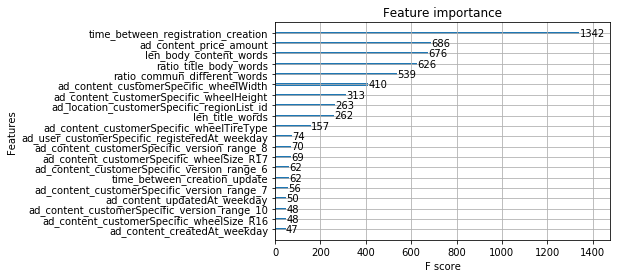

In [840]:
plot_importance(model, max_num_features=20)

### D - MODEL VALIDATION 

In [841]:
y_pred = model.predict_proba(X_val)

ROC AUC=0.868


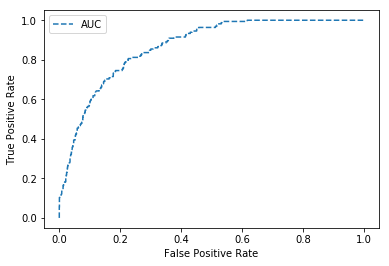

In [842]:
# calculate scores
auc = roc_auc_score(y_val, y_pred[:, 1])

# summarize scores
print('ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

In [843]:
for thrs in np.arange(0.1, 0.9, 0.05):
    y_pred_cm = (y_pred[:,1] > thrs)*1
    print("threshold : ", round(thrs,2), ", F1 score : ", f1_score(y_val,y_pred_cm), ", % of predicted positifs : ", np.mean(y_pred_cm==1))
    print("Recall : ", recall_score(y_val, y_pred_cm), ", Precision : ", precision_score(y_val, y_pred_cm))
    print("#"*50)

threshold :  0.1 , F1 score :  0.2738095238095238 , % of predicted positifs :  0.31656027037176115
Recall :  0.8363636363636363 , Precision :  0.16370106761565836
##################################################
threshold :  0.15 , F1 score :  0.30434782608695654 , % of predicted positifs :  0.2662410814870447
Recall :  0.806060606060606 , Precision :  0.18758815232722145
##################################################
threshold :  0.2 , F1 score :  0.31701030927835055 , % of predicted positifs :  0.22944048066090875
Recall :  0.7454545454545455 , Precision :  0.20130932896890344
##################################################
threshold :  0.25 , F1 score :  0.3309957924263674 , % of predicted positifs :  0.2057829515583928
Recall :  0.7151515151515152 , Precision :  0.21532846715328466
##################################################
threshold :  0.3 , F1 score :  0.3502304147465438 , % of predicted positifs :  0.1825009387908374
Recall :  0.6909090909090909 , Precision :  0

[[1922  576]
 [  32  133]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      2498
           1       0.19      0.81      0.30       165

    accuracy                           0.77      2663
   macro avg       0.59      0.79      0.58      2663
weighted avg       0.93      0.77      0.83      2663



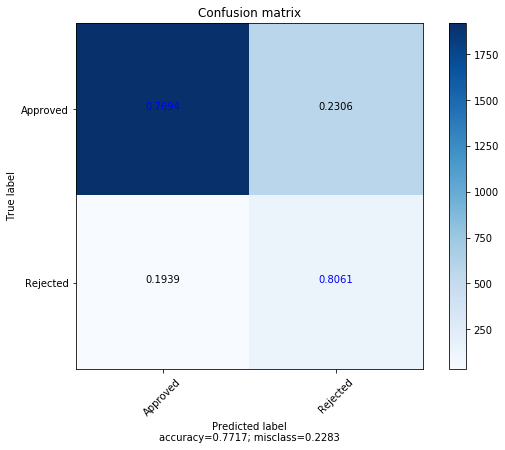

In [844]:
thrs = 0.15
y_pred_cm = (y_pred[:, 1] > thrs)*1
print(confusion_matrix(y_val, y_pred_cm))

print(classification_report(y_val, y_pred_cm))

plot_confusion(confusion_matrix(y_val, y_pred_cm),
              ['Approved', 'Rejected'],
              title='Confusion matrix',
              cmap=None,
              normalize=True)

Like the last model, my model have high recall but a very low precision. That means he's pretty good at detecting a `Rejected` as such, but flag some `Accepted` ads as `Rejected` sometimes.

### E - Model Prediction

In [845]:
y_test_pred = model.predict_proba(current_test_data)

y_test = (y_test_pred[:, 1] > thrs)*1
y_test = ["rejected" if x==1 else "approved" for x in y_test]

test_data_by_category[category][target_column] = y_test

In [846]:
Counter(y_test)

Counter({'rejected': 1229, 'approved': 2953})

## 3) Two-wheeled motor vehicles

### A - EDA 

In [1141]:
category = "Two-wheeled motor vehicles"
current_data = train_data_by_category[category].copy()

current_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 31 to 399902
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     2346 non-null   object 
 1   ad_taskId                                      2346 non-null   object 
 2   ad_content_title                               2346 non-null   object 
 3   ad_content_body                                2173 non-null   object 
 4   ad_content_price_amount                        2255 non-null   float64
 5   ad_content_customerSpecific_device             2346 non-null   object 
 6   ad_content_customerSpecific_year               2346 non-null   float64
 7   ad_location_customerSpecific_regionList_id     2346 non-null   float64
 8   ad_content_customerSpecific_autoMotoModel      1787 non-null   object 
 9   ad_content_customerSpecific_autoMotoBody       23

In [1142]:
current_data.describe()

ad_content_price_amount  ad_content_customerSpecific_year  \
count             2.255000e+03                       2346.000000   
mean              2.205031e+09                       2008.505968   
std               3.173306e+09                         11.166093   
min               1.976970e+05                       1900.000000   
25%               4.186524e+08                       2003.000000   
50%               9.698780e+08                       2013.000000   
75%               2.791016e+09                       2017.000000   
max               3.267814e+10                       2018.000000   

       ad_location_customerSpecific_regionList_id  \
count                                 2346.000000   
mean                                     5.403666   
std                                      4.298595   
min                                      1.000000   
25%                                      1.000000   
50%                                      5.000000   
75%                                      8.000000   
max                                     35.000000   

       ad_content_customerSpecific_autoMotoBody  \
count                               2311.000000   
mean                               57120.306794   
std                               232117.450739   
min                                    1.000000   
25%                                    1.000000   
50%                                    1.000000   
75%                                    5.000000   
max                               999999.000000   

       ad_content_customerSpecific_autoCondition  \
count                                2346.000000   
mean                                    7.619352   
std                                     0.563677   
min                                     5.000000   
25%                                     7.000000   
50%                                     8.000000   
75%                                     8.000000   
max                                     8.000000   

       ad_customerSpecific_moderationDecision  time_between_creation_update  \
count                             2346.000000                   2346.000000   
mean                                 0.057971                     30.023444   
std                                  0.233738                    150.944008   
min                                  0.000000                      0.000000   
25%                                  0.000000                      0.000000   
50%                                  0.000000                      0.000000   
75%                                  0.000000                      0.000000   
max                                  1.000000                   1928.000000   

       time_between_registration_creation  ad_content_createdAt_weekday  \
count                         2173.000000                   2346.000000   
mean                          1634.382421                      0.166667   
std                           1044.583726                      0.372757   
min                           -250.000000                      0.000000   
25%                            651.000000                      0.000000   
50%                           1815.000000                      0.000000   
75%                           2405.000000                      0.000000   
max                           3245.000000                      1.000000   

       ad_content_updatedAt_weekday  \
count                   2346.000000   
mean                       0.166240   
std                        0.372376   
min                        0.000000   
25%                        0.000000   
50%                        0.000000   
75%                        0.000000   
max                        1.000000   

       ad_user_customerSpecific_registeredAt_weekday  len_title_words  \
count                                    2346.000000      2346.000000   
mean                                        0.176471         3.010656   
std                         

In [1143]:
current_data.isna().sum()

ad_batchId                                         0
ad_taskId                                          0
ad_content_title                                   0
ad_content_body                                  173
ad_content_price_amount                           91
ad_content_customerSpecific_device                 0
ad_content_customerSpecific_year                   0
ad_location_customerSpecific_regionList_id         0
ad_content_customerSpecific_autoMotoModel        559
ad_content_customerSpecific_autoMotoBody          35
ad_content_customerSpecific_autoCondition          0
ad_customerSpecific_moderationDecision             0
time_between_creation_update                       0
time_between_registration_creation               173
ad_content_createdAt_weekday                       0
ad_content_updatedAt_weekday                       0
ad_user_customerSpecific_registeredAt_weekday      0
len_title_words                                    0
len_body_content_words                        

In [1144]:
current_test_data = test_data_by_category[category].copy()
current_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 1 to 100143
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     684 non-null    object 
 1   ad_taskId                                      684 non-null    object 
 2   ad_content_title                               684 non-null    object 
 3   ad_content_body                                623 non-null    object 
 4   ad_content_price_amount                        655 non-null    float64
 5   ad_content_customerSpecific_device             684 non-null    object 
 6   ad_content_customerSpecific_year               684 non-null    float64
 7   ad_location_customerSpecific_regionList_id     684 non-null    float64
 8   ad_content_customerSpecific_autoMotoModel      544 non-null    object 
 9   ad_content_customerSpecific_autoMotoBody       678 

In [1145]:
current_test_data.isna().sum()

ad_batchId                                         0
ad_taskId                                          0
ad_content_title                                   0
ad_content_body                                   61
ad_content_price_amount                           29
ad_content_customerSpecific_device                 0
ad_content_customerSpecific_year                   0
ad_location_customerSpecific_regionList_id         0
ad_content_customerSpecific_autoMotoModel        140
ad_content_customerSpecific_autoMotoBody           6
ad_content_customerSpecific_autoCondition          0
time_between_creation_update                       0
time_between_registration_creation                37
ad_content_createdAt_weekday                       0
ad_content_updatedAt_weekday                       0
ad_user_customerSpecific_registeredAt_weekday      0
len_title_words                                    0
len_body_content_words                             0
ratio_title_body_words                        

#### PLOT THE DISTRIBUTION OF NUMERICAL DATA IN EACH CLASS


/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


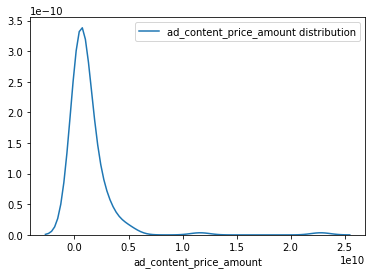

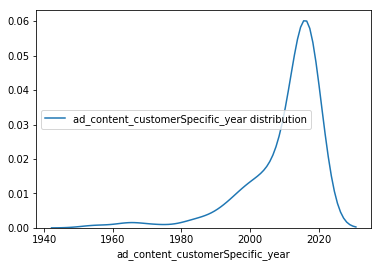

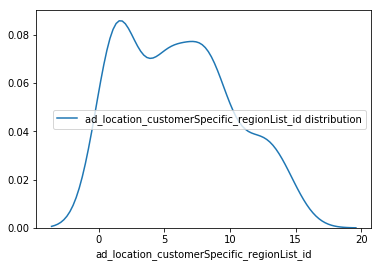

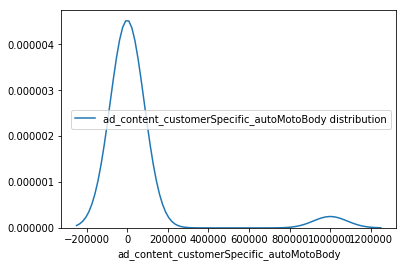

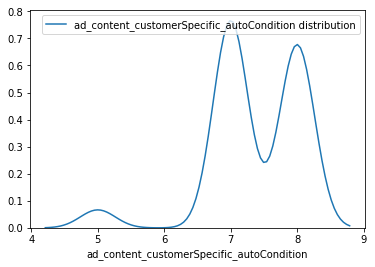

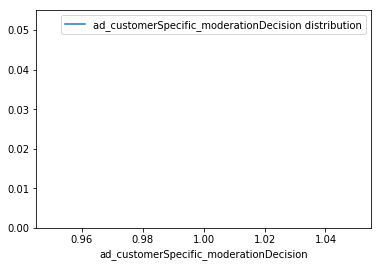

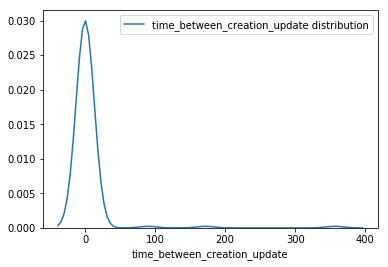

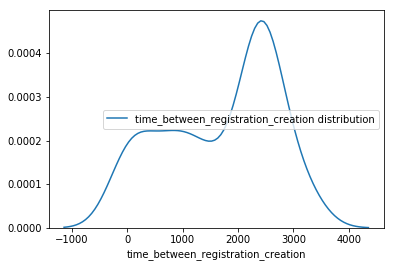

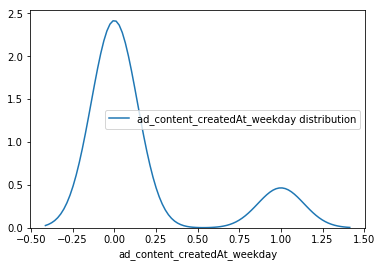

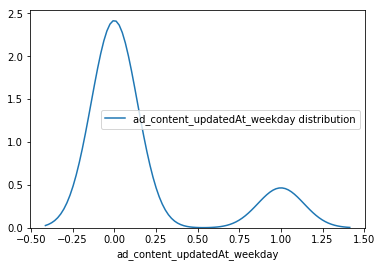

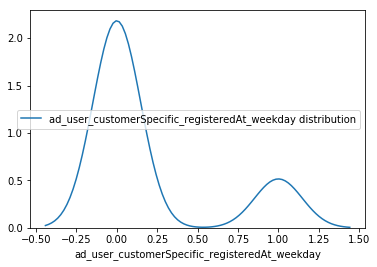

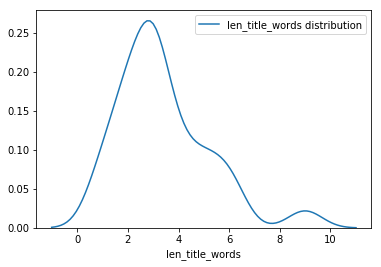

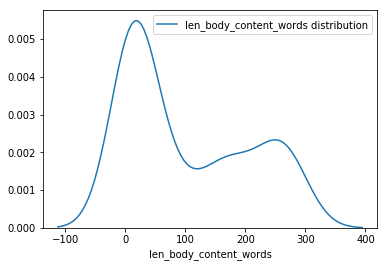

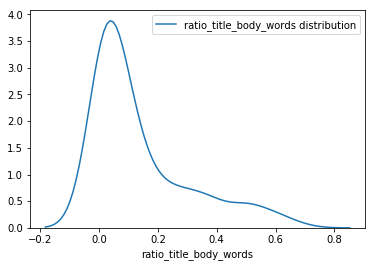

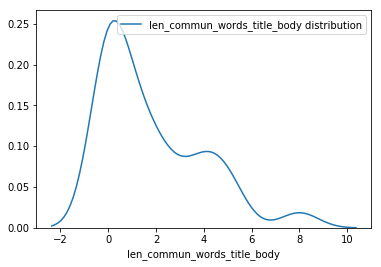

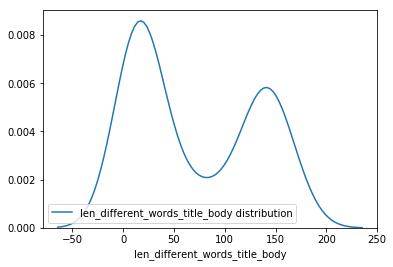

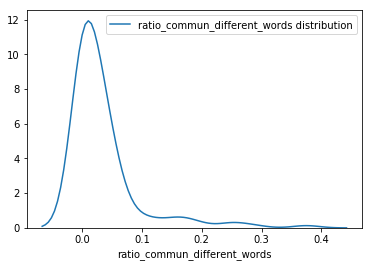

In [1146]:
## CLASS REJECTED
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==1][col], hist=False, label=col+" distribution")

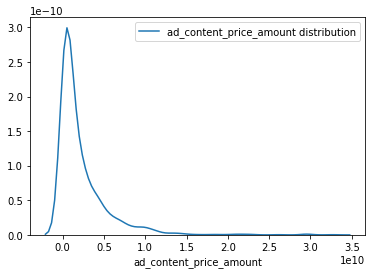

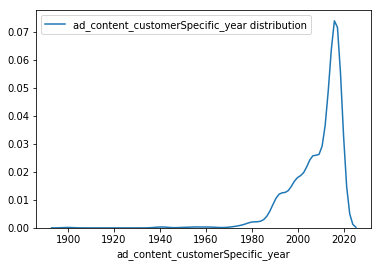

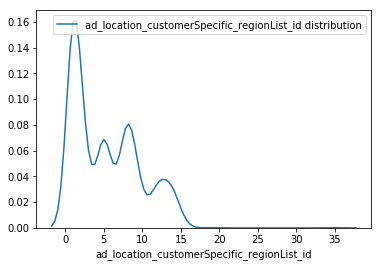

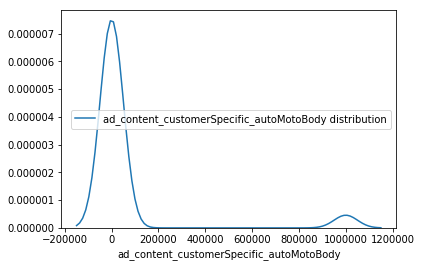

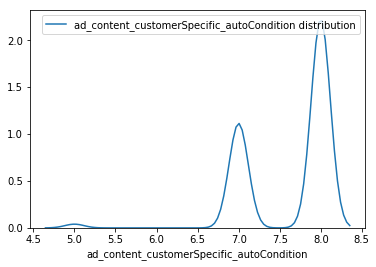

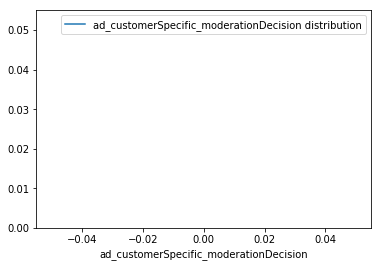

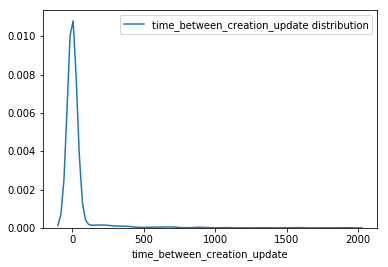

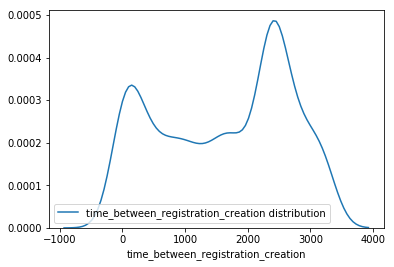

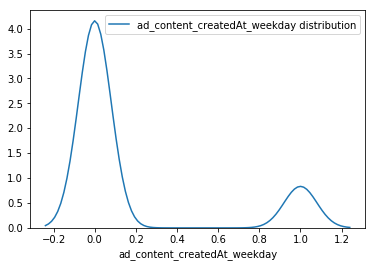

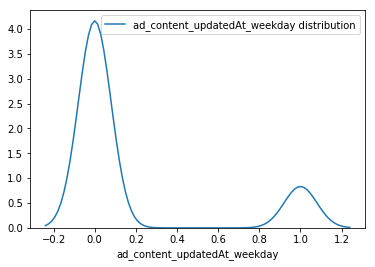

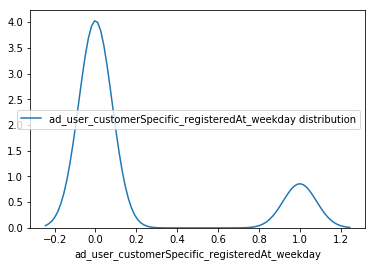

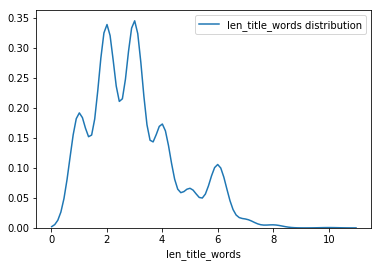

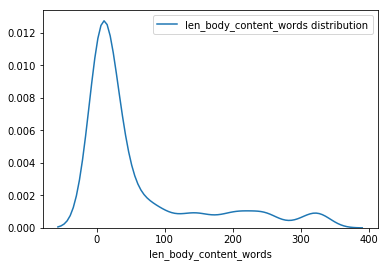

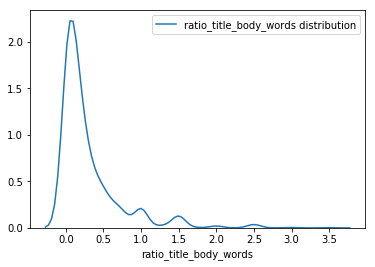

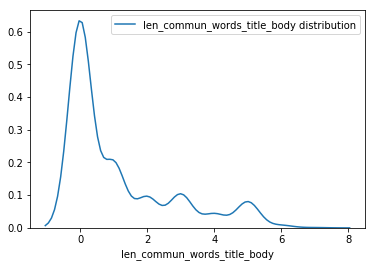

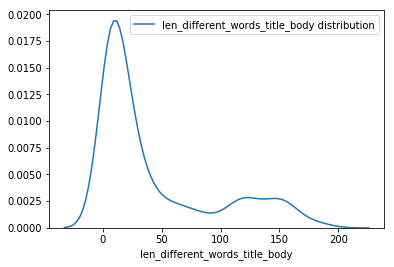

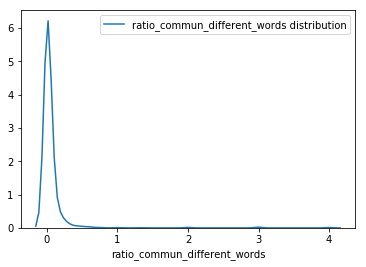

In [1147]:
## CLASS APPROVED 
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==0][col], hist=False, label=col+" distribution")

### B - DATA PREPARATION

In [877]:
columns_to_drop = ['ad_batchId', 'ad_taskId','ad_content_title', 'ad_content_body','len_commun_words_title_body','len_different_words_title_body']
current_data.drop(columns=columns_to_drop, inplace=True)
current_test_data.drop(columns=columns_to_drop, inplace=True)

In [878]:
numerical_columns = current_data.select_dtypes(include=[np.number]).columns
categorical_columns = current_data.drop(columns=target_column).select_dtypes(exclude=[np.number]).columns

## ENCODE CATEGORICAL VARIABLES 
current_data_features = current_data.drop(columns=target_column)
current_data_target = current_data[target_column]

current_data_features= pd.get_dummies(data=current_data_features, columns=categorical_columns)
current_test_data = pd.get_dummies(data=current_test_data, columns=categorical_columns)

current_data_features, current_test_data = current_data_features.align(current_test_data, join='left', axis=1)

## SPLIT DATA INTO TRAIN AND VALIDATION SETS 
X_train, X_val, y_train, y_val = train_test_split(current_data_features, current_data_target,
                                                    stratify=current_data_target, 
                                                    test_size=0.20)

In [879]:
imb_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
print(f"Classes are imbalanced with a ratio of {np.round(imb_weight*100, 2)}% of 0/1")

Classes are imbalanced with a ratio of 1621.1% of 0/1


### C - BUILD CLASSIFICATION MODEL

In [881]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=7,
                          scale_pos_weight= imb_weight,
                          max_delta_step= 1.8, gamma= 3, 
                         random_state=42, 
                         learning_rate=0.1,
                          min_child_weight = 10 ,n_jobs=4)

model.fit(X_train,y_train)

XGBClassifier(gamma=3, max_delta_step=1.8, max_depth=7, min_child_weight=10,
              n_estimators=200, n_jobs=4, random_state=42,
              scale_pos_weight=16.211009174311926)

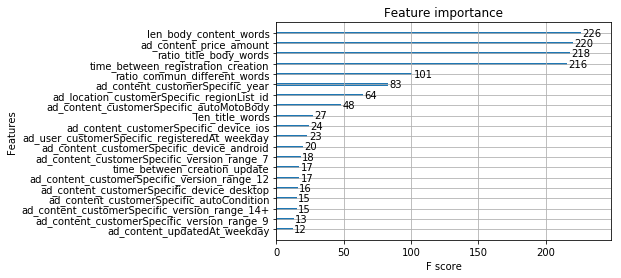

In [882]:
plot_importance(model, max_num_features=20)

### D - MODEL VALIDATION 

In [885]:
y_pred = model.predict_proba(X_val)

ROC AUC=0.816


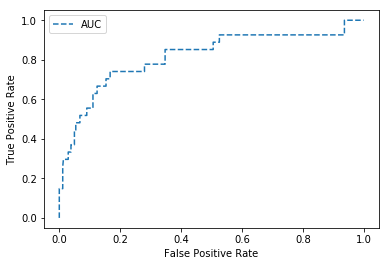

In [886]:
# calculate scores
auc = roc_auc_score(y_val, y_pred[:, 1])

# summarize scores
print('ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

In [887]:
for thrs in np.arange(0.1, 0.9, 0.05):
    y_pred_cm = (y_pred[:,1] > thrs)*1
    print("threshold : ", round(thrs,2), ", F1 score : ", f1_score(y_val,y_pred_cm), ", % of predicted positifs : ", np.mean(y_pred_cm==1))
    print("Recall : ", recall_score(y_val, y_pred_cm), ", Precision : ", precision_score(y_val, y_pred_cm))
    print("#"*50)

threshold :  0.1 , F1 score :  0.2222222222222222 , % of predicted positifs :  0.3829787234042553
Recall :  0.8518518518518519 , Precision :  0.12777777777777777
##################################################
threshold :  0.15 , F1 score :  0.2564102564102564 , % of predicted positifs :  0.274468085106383
Recall :  0.7407407407407407 , Precision :  0.15503875968992248
##################################################
threshold :  0.2 , F1 score :  0.32 , % of predicted positifs :  0.20851063829787234
Recall :  0.7407407407407407 , Precision :  0.20408163265306123
##################################################
threshold :  0.25 , F1 score :  0.33962264150943394 , % of predicted positifs :  0.16808510638297872
Recall :  0.6666666666666666 , Precision :  0.22784810126582278
##################################################
threshold :  0.3 , F1 score :  0.34782608695652173 , % of predicted positifs :  0.13829787234042554
Recall :  0.5925925925925926 , Precision :  0.246153846153

[[365  78]
 [  7  20]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.90       443
           1       0.20      0.74      0.32        27

    accuracy                           0.82       470
   macro avg       0.59      0.78      0.61       470
weighted avg       0.94      0.82      0.86       470



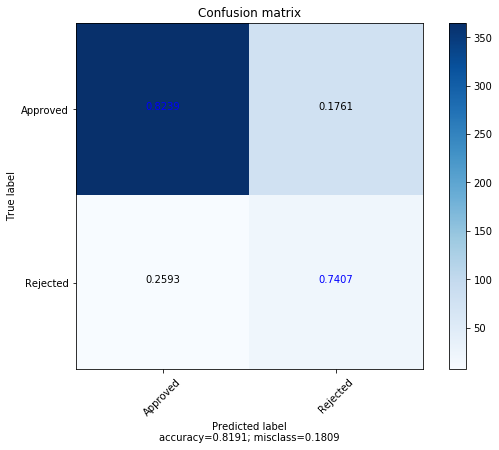

In [888]:
thrs = 0.2
y_pred_cm = (y_pred[:, 1] > thrs)*1
print(confusion_matrix(y_val, y_pred_cm))

print(classification_report(y_val, y_pred_cm))

plot_confusion(confusion_matrix(y_val, y_pred_cm),
              ['Approved', 'Rejected'],
              title='Confusion matrix',
              cmap=None,
              normalize=True)

Like the last model, my model have high recall but a very low precision. That means he's pretty good at detecting a `Rejected` as such, but flag some `Accepted` ads as `Rejected` sometimes.

### E - MODEL PREDICTIONS 

In [889]:
y_test_pred = model.predict_proba(current_test_data)

y_test = (y_test_pred[:, 1] > thrs)*1
y_test = ["rejected" if x==1 else "approved" for x in y_test]

test_data_by_category[category][target_column] = y_test

In [890]:
Counter(y_test)

Counter({'approved': 499, 'rejected': 185})

## 4) Used cars

### A - EDA

In [1206]:
category = "Used cars"
current_data = train_data_by_category[category].copy()

current_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151878 entries, 0 to 399996
Data columns (total 32 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   ad_batchId                                     151878 non-null  object 
 1   ad_taskId                                      151878 non-null  object 
 2   ad_content_title                               151878 non-null  object 
 3   ad_content_body                                124391 non-null  object 
 4   ad_content_price_amount                        151871 non-null  float64
 5   ad_content_customerSpecific_device             151878 non-null  object 
 6   ad_content_customerSpecific_autoCarBody        151876 non-null  float64
 7   ad_content_customerSpecific_autoCarOrder       151872 non-null  float64
 8   ad_content_customerSpecific_year               151877 non-null  float64
 9   ad_content_customerSpecific_autoCarVo

In [1207]:
current_data.describe()

ad_content_price_amount  ad_content_customerSpecific_autoCarBody  \
count             1.518710e+05                            151876.000000   
mean              3.410260e+13                                14.374951   
std               9.378115e+15                                 5.591852   
min               2.325847e+03                                11.000000   
25%               1.744385e+09                                11.000000   
50%               3.256185e+09                                11.000000   
75%               6.628663e+09                                14.000000   
max               2.584274e+18                                32.000000   

       ad_content_customerSpecific_autoCarOrder  \
count                             151872.000000   
mean                                   1.033851   
std                                    0.180846   
min                                    1.000000   
25%                                    1.000000   
50%                                    1.000000   
75%                                    1.000000   
max                                    2.000000   

       ad_content_customerSpecific_year  \
count                     151877.000000   
mean                        2001.304312   
std                            8.659137   
min                         1900.000000   
25%                         1994.000000   
50%                         2001.000000   
75%                         2008.000000   
max                         2018.000000   

       ad_content_customerSpecific_autoCarVolume  \
count                              151841.000000   
mean                                    2.216971   
std                                     0.786017   
min                                     0.100000   
25%                                     1.600000   
50%                                     2.000000   
75%                                     2.500000   
max                                     9.900000   

       ad_content_customerSpecific_autoCarTransm  \
count                              151877.000000   
mean                                    2.036332   
std                                    33.484339   
min                                     1.000000   
25%                                     1.000000   
50%                                     1.000000   
75%                                     2.000000   
max                                  2345.000000   

       ad_content_customerSpecific_autoColor  \
count                          139147.000000   
mean                                5.214543   
std                                 5.151795   
min                                 1.000000   
25%                                 2.000000   
50%                                 4.000000   
75%                                 6.000000   
max                                23.000000   

       ad_content_customerSpecific_autoCustom  \
count                           151874.000000   
mean                                 1.941998   
std                                  0.233748   
min                                  1.000000   
25%                                  2.000000   
50%                                  2.000000   
75%                                  2.000000   
max                                  2.000000   

       ad_content_customerSpecific_autoEmergency  \
count                              151877.000000   
mean                                    1.045287   
std                                     0.275059   
min                                     1.000000   
25%                                     1.000000   
50%                                     1.000000   
75%                                     1.000000   
max                                     3.000000   

       ad_content_customerSpecific_autoCarGrbody  ...  \
count                              151867.000000  ...   
mean                                    1.336070  ...   
std                           

In [1208]:
current_data.isna().sum()

ad_batchId                                           0
ad_taskId                                            0
ad_content_title                                     0
ad_content_body                                  27487
ad_content_price_amount                              7
ad_content_customerSpecific_device                   0
ad_content_customerSpecific_autoCarBody              2
ad_content_customerSpecific_autoCarOrder             6
ad_content_customerSpecific_year                     1
ad_content_customerSpecific_autoCarVolume           37
ad_content_customerSpecific_autoCarTransm            1
ad_content_customerSpecific_autoColor            12731
ad_content_customerSpecific_autoCustom               4
ad_content_customerSpecific_autoEmergency            1
ad_content_customerSpecific_autoCarGrbody           11
ad_content_customerSpecific_carDwheel            17907
ad_location_customerSpecific_regionList_id           0
ad_customerSpecific_moderationDecision               0
time_betwe

In [1209]:
current_test_data = test_data_by_category[category].copy()
current_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44016 entries, 0 to 100230
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     44016 non-null  object 
 1   ad_taskId                                      44016 non-null  object 
 2   ad_content_title                               44016 non-null  object 
 3   ad_content_body                                36115 non-null  object 
 4   ad_content_price_amount                        44015 non-null  float64
 5   ad_content_customerSpecific_device             44016 non-null  object 
 6   ad_content_customerSpecific_autoCarBody        44016 non-null  float64
 7   ad_content_customerSpecific_autoCarOrder       44015 non-null  float64
 8   ad_content_customerSpecific_year               44016 non-null  float64
 9   ad_content_customerSpecific_autoCarVolume      44

In [1210]:
current_test_data.isna().sum()

ad_batchId                                          0
ad_taskId                                           0
ad_content_title                                    0
ad_content_body                                  7901
ad_content_price_amount                             1
ad_content_customerSpecific_device                  0
ad_content_customerSpecific_autoCarBody             0
ad_content_customerSpecific_autoCarOrder            1
ad_content_customerSpecific_year                    0
ad_content_customerSpecific_autoCarVolume          14
ad_content_customerSpecific_autoCarTransm           0
ad_content_customerSpecific_autoColor            3788
ad_content_customerSpecific_autoCustom              0
ad_content_customerSpecific_autoEmergency           1
ad_content_customerSpecific_autoCarGrbody           4
ad_content_customerSpecific_carDwheel            5283
ad_location_customerSpecific_regionList_id          0
time_between_creation_update                        0
time_between_registration_cr

#### PLOT THE DISTRIBUTION OF NUMERICAL DATA IN EACH CLASS


/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


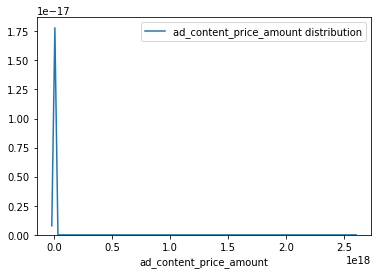

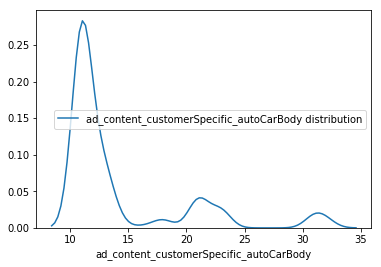

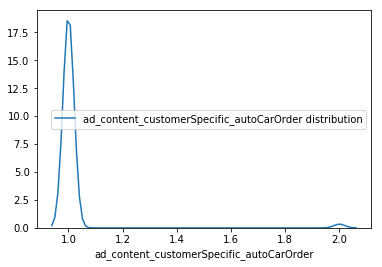

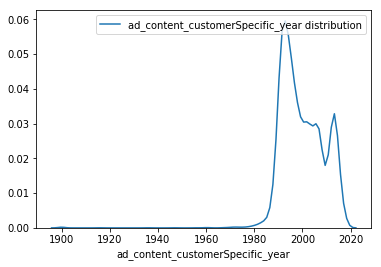

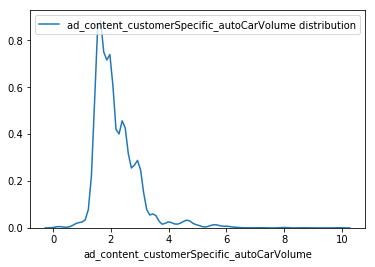

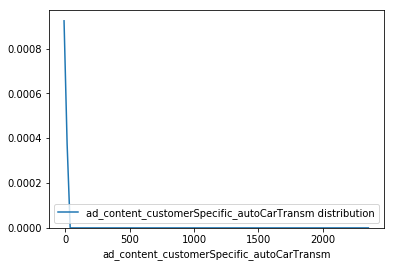

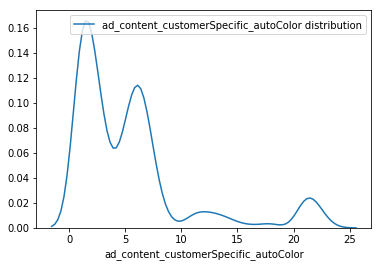

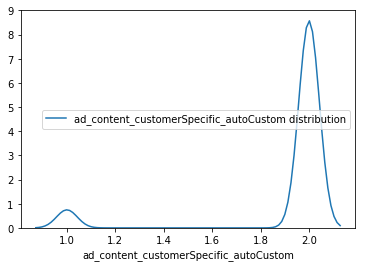

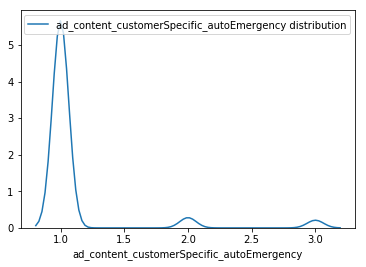

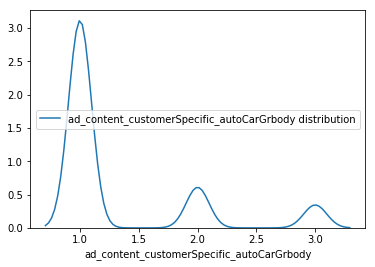

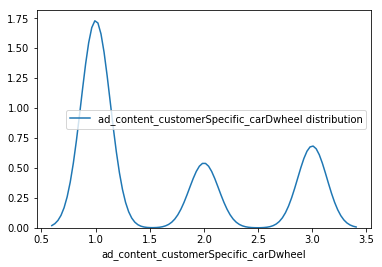

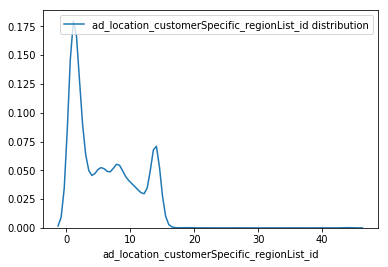

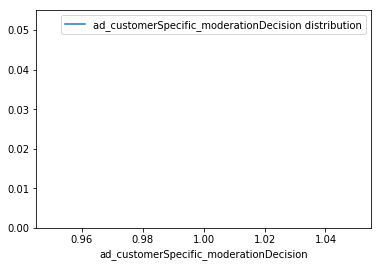

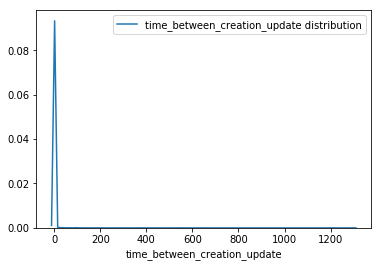

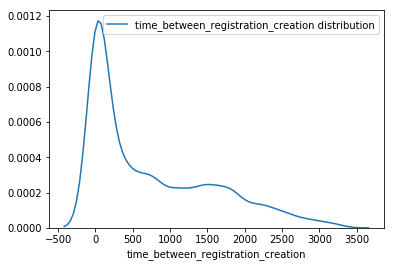

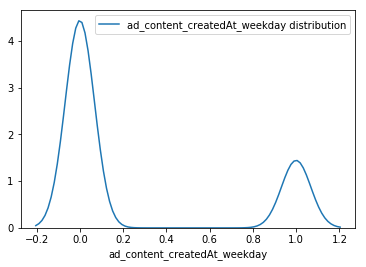

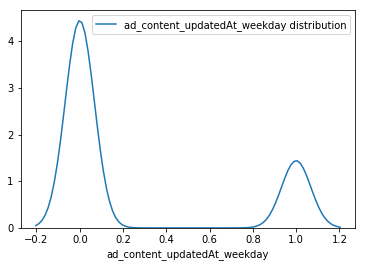

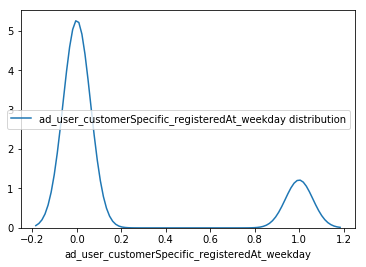

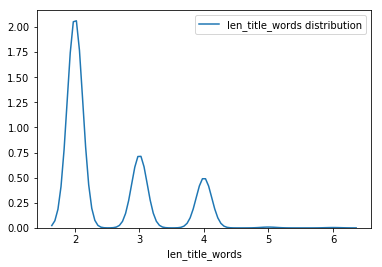

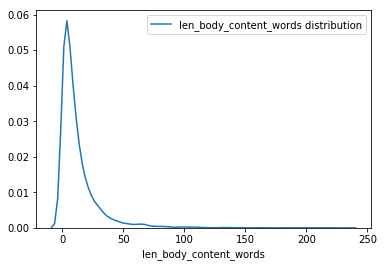

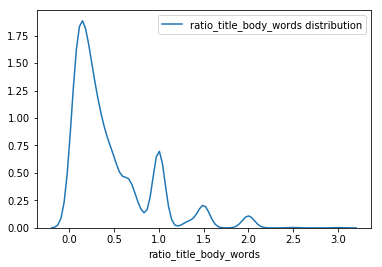

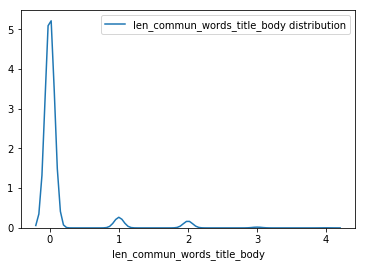

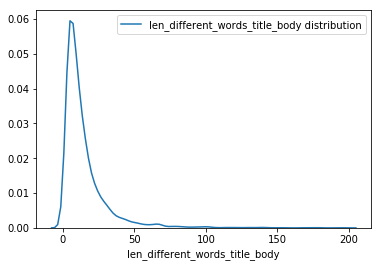

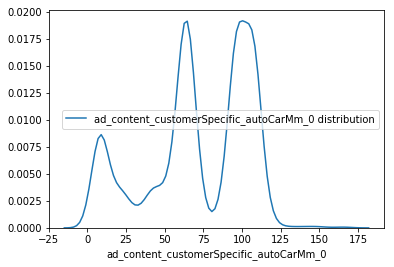

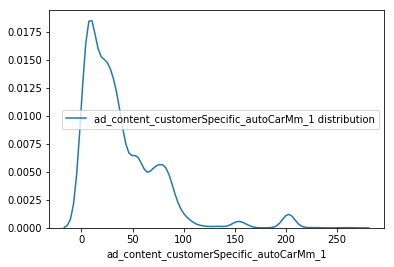

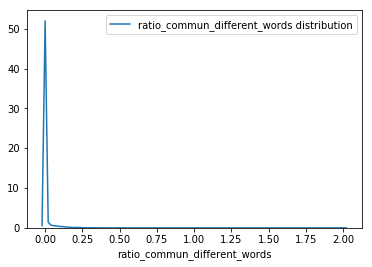

In [1211]:
## CLASS REJECTED
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==1][col], hist=False, label=col+" distribution")


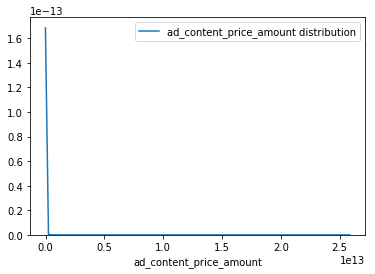

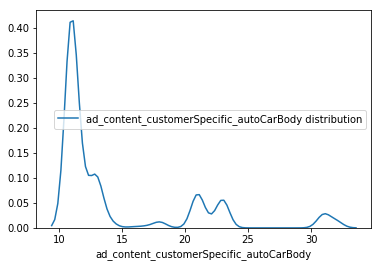

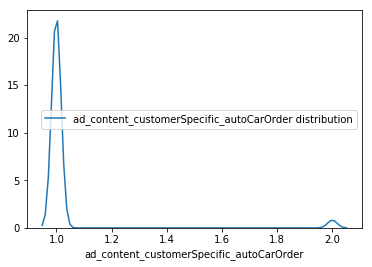

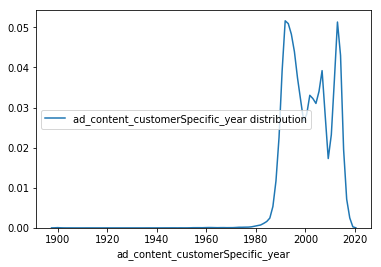

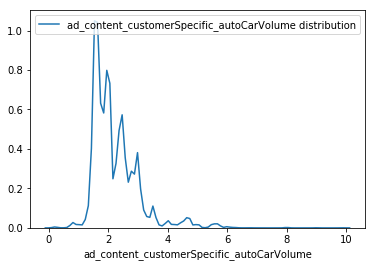

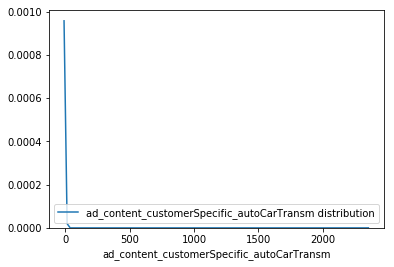

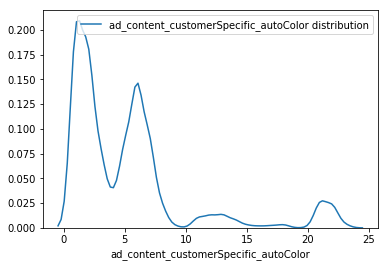

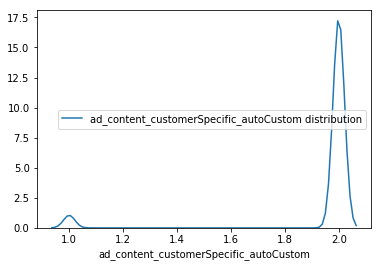

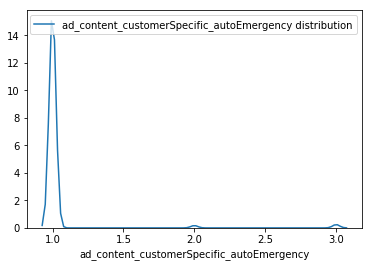

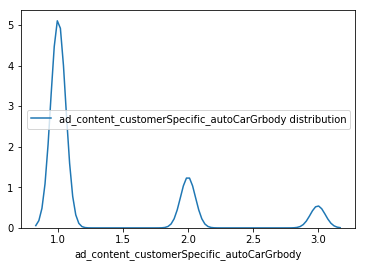

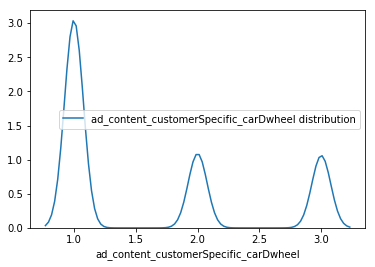

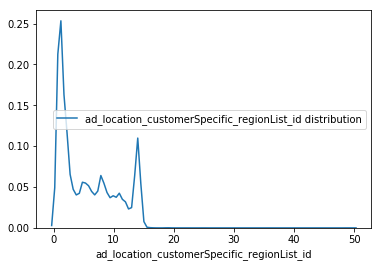

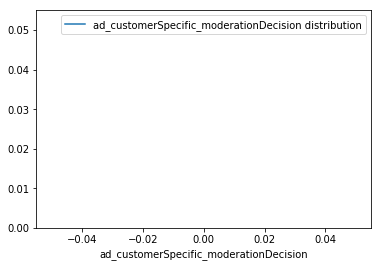

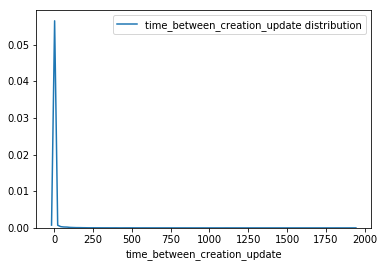

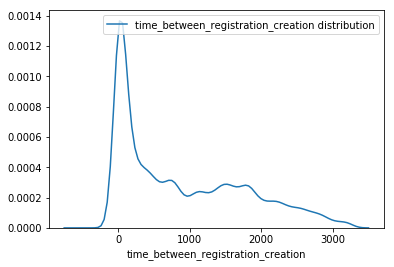

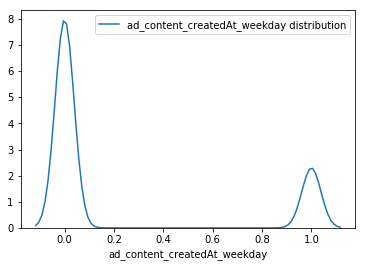

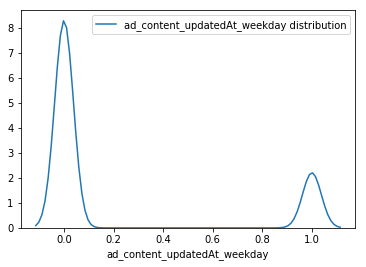

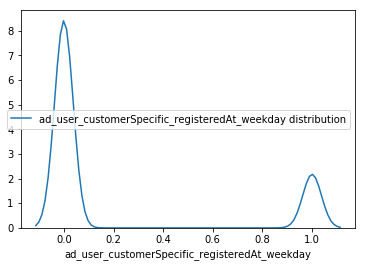

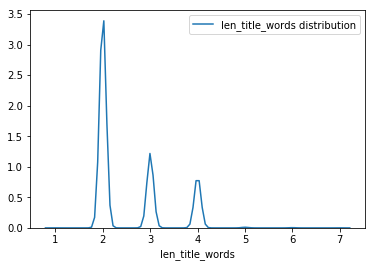

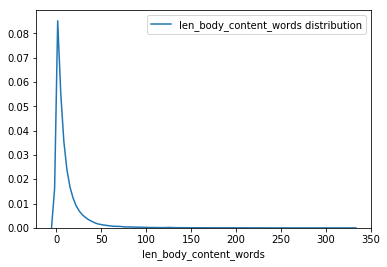

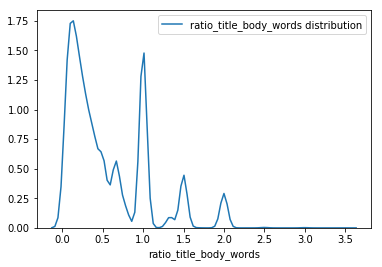

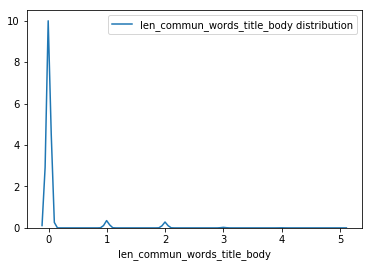

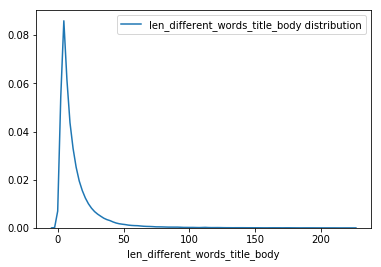

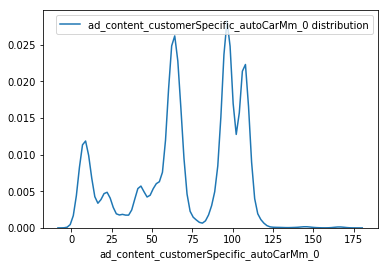

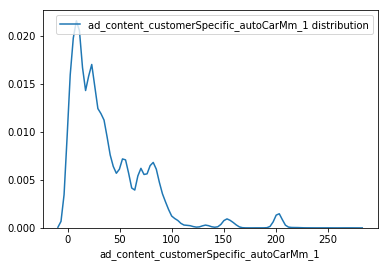

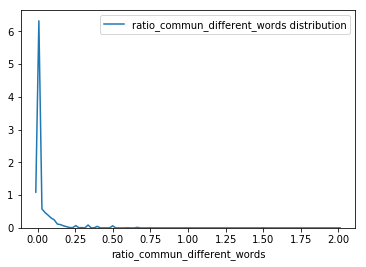

In [1212]:
## CLASS APPROVED 
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==0][col], hist=False, label=col+" distribution")

### B - DATA PREPATATION 

In [1213]:
columns_to_drop = ['ad_batchId', 'ad_taskId','ad_content_title', 'ad_content_body','ad_content_customerSpecific_carDwheel','ad_content_customerSpecific_autoColor']

current_data.drop(columns=columns_to_drop, inplace=True)
current_test_data.drop(columns=columns_to_drop, inplace=True)

In [1214]:
numerical_columns = current_data.select_dtypes(include=[np.number]).columns
categorical_columns = current_data.drop(columns=target_column).select_dtypes(exclude=[np.number]).columns

In [1215]:
## ENCODE CATEGORICAL VARIABLES 
current_data_features = current_data.drop(columns=target_column)
current_data_target = current_data[target_column]

current_data_features= pd.get_dummies(data=current_data_features, columns=categorical_columns)
current_test_data = pd.get_dummies(data=current_test_data, columns=categorical_columns)

current_data_features, current_test_data = current_data_features.align(current_test_data, join='left', axis=1)

## SPLIT DATA INTO TRAIN AND VALIDATION SETS 
X_train, X_val, y_train, y_val = train_test_split(current_data_features, current_data_target,
                                                    stratify=current_data_target, 
                                                    test_size=0.20)

In [1216]:
imb_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
print(f"Classes are imbalanced with a ratio of {np.round(imb_weight*100, 2)}% of 0/1")

Classes are imbalanced with a ratio of 1376.15% of 0/1


### C - BUILD CLASSIFICATION MODEL

In [1222]:
model = xgb.XGBClassifier(n_estimators=500, max_depth=7,
                          scale_pos_weight= math.sqrt(imb_weight)-1,
                          max_delta_step= 1.8, 
                         random_state=42, 
                         learning_rate=0.1,
                          min_child_weight = 10 ,n_jobs=4)

model.fit(X_train,y_train)

XGBClassifier(max_delta_step=1.8, max_depth=7, min_child_weight=10,
              n_estimators=500, n_jobs=4, random_state=42,
              scale_pos_weight=2.709651110211659)

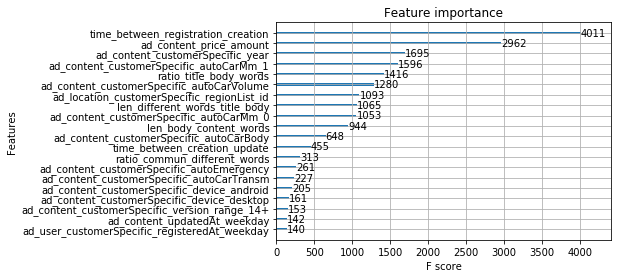

In [1223]:
plot_importance(model, max_num_features=20)

### D - MODEL VALIDATION 

In [1224]:
y_pred = model.predict_proba(X_val)

ROC AUC=0.766


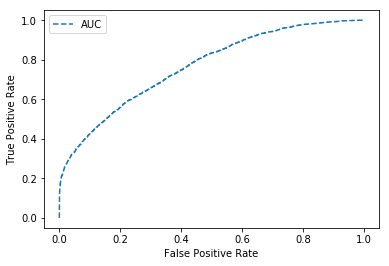

In [1225]:
# calculate scores
auc = roc_auc_score(y_val, y_pred[:, 1])

# summarize scores
print('ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

In [1226]:
for thrs in np.arange(0.1, 0.9, 0.05):
    y_pred_cm = (y_pred[:,1] > thrs)*1
    print("threshold : ", round(thrs,2), ", F1 score : ", f1_score(y_val,y_pred_cm), ", % of predicted positifs : ", np.mean(y_pred_cm==1))
    print("Recall : ", recall_score(y_val, y_pred_cm), ", Precision : ", precision_score(y_val, y_pred_cm))
    print("#"*50)

threshold :  0.1 , F1 score :  0.19744427934621098 , % of predicted positifs :  0.4861403739794575
Recall :  0.8070942662779398 , Precision :  0.11248053091352339
##################################################
threshold :  0.15 , F1 score :  0.2349883491665173 , % of predicted positifs :  0.2995786146958125
Recall :  0.6370262390670554 , Precision :  0.14406593406593407
##################################################
threshold :  0.2 , F1 score :  0.27935278661319324 , % of predicted positifs :  0.17029892020015802
Recall :  0.49076773566569487 , Precision :  0.19524453895225208
##################################################
threshold :  0.25 , F1 score :  0.3156640857653365 , % of predicted positifs :  0.09807084540426653
Recall :  0.38629737609329445 , Precision :  0.26686807653575023
##################################################
threshold :  0.3 , F1 score :  0.3355196770938446 , % of predicted positifs :  0.06274690545167237
Recall :  0.3231292517006803 , Precision 

[[20529  7789]
 [  747  1311]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.83     28318
           1       0.14      0.64      0.23      2058

    accuracy                           0.72     30376
   macro avg       0.55      0.68      0.53     30376
weighted avg       0.91      0.72      0.79     30376



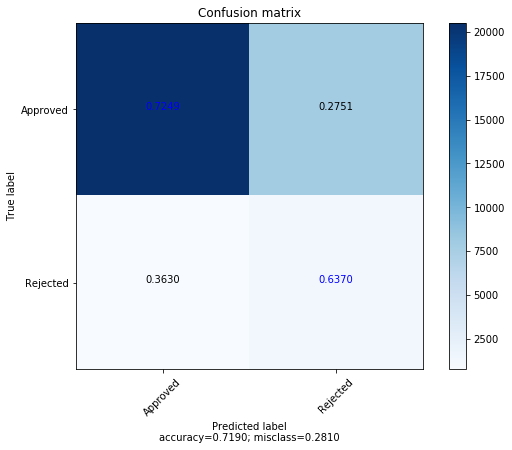

In [1227]:
thrs = 0.15
y_pred_cm = (y_pred[:, 1] > thrs)*1
print(confusion_matrix(y_val, y_pred_cm))

print(classification_report(y_val, y_pred_cm))

plot_confusion(confusion_matrix(y_val, y_pred_cm),
              ['Approved', 'Rejected'],
              title='Confusion matrix',
              cmap=None,
              normalize=True)

In [ ]:
This model d

### E - MODEL PREDICTIONS 

In [1228]:
y_test_pred = model.predict_proba(current_test_data)

y_test = (y_test_pred[:, 1] > thrs)*1
y_test = ["rejected" if x==1 else "approved" for x in y_test]

test_data_by_category[category][target_column] = y_test

In [1229]:
Counter(y_test)

Counter({'rejected': 38482, 'approved': 5534})

## 5) Wheel disks

### A - EDA 

In [1155]:
category = "Wheel disks"
current_data = train_data_by_category[category].copy()

current_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8848 entries, 6 to 399980
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     8848 non-null   object 
 1   ad_taskId                                      8848 non-null   object 
 2   ad_content_title                               8848 non-null   object 
 3   ad_content_body                                8390 non-null   object 
 4   ad_content_price_amount                        8847 non-null   float64
 5   ad_content_customerSpecific_device             8848 non-null   object 
 6   ad_content_customerSpecific_autoCarOrder       8847 non-null   float64
 7   ad_location_customerSpecific_regionList_id     8847 non-null   float64
 8   ad_content_customerSpecific_spareCondition     8847 non-null   float64
 9   ad_content_customerSpecific_wheelDiscType      884

In [1156]:
current_data.isna().sum()

ad_batchId                                         0
ad_taskId                                          0
ad_content_title                                   0
ad_content_body                                  458
ad_content_price_amount                            1
ad_content_customerSpecific_device                 0
ad_content_customerSpecific_autoCarOrder           1
ad_location_customerSpecific_regionList_id         1
ad_content_customerSpecific_spareCondition         1
ad_content_customerSpecific_wheelDiscType          2
ad_content_customerSpecific_wheelSize              2
ad_content_customerSpecific_wheelPcd               2
ad_customerSpecific_moderationDecision             0
time_between_creation_update                       0
time_between_registration_creation               338
ad_content_createdAt_weekday                       0
ad_content_updatedAt_weekday                       0
ad_user_customerSpecific_registeredAt_weekday      0
len_title_words                               

In [1157]:
current_test_data = test_data_by_category[category].copy()
current_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2322 entries, 88 to 100225
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ad_batchId                                     2322 non-null   object 
 1   ad_taskId                                      2322 non-null   object 
 2   ad_content_title                               2322 non-null   object 
 3   ad_content_body                                2235 non-null   object 
 4   ad_content_price_amount                        2321 non-null   float64
 5   ad_content_customerSpecific_device             2322 non-null   object 
 6   ad_content_customerSpecific_autoCarOrder       2322 non-null   float64
 7   ad_location_customerSpecific_regionList_id     2322 non-null   float64
 8   ad_content_customerSpecific_spareCondition     2322 non-null   float64
 9   ad_content_customerSpecific_wheelDiscType      23

In [1158]:
current_test_data.isna().sum()

ad_batchId                                         0
ad_taskId                                          0
ad_content_title                                   0
ad_content_body                                   87
ad_content_price_amount                            1
ad_content_customerSpecific_device                 0
ad_content_customerSpecific_autoCarOrder           0
ad_location_customerSpecific_regionList_id         0
ad_content_customerSpecific_spareCondition         0
ad_content_customerSpecific_wheelDiscType          0
ad_content_customerSpecific_wheelSize              0
ad_content_customerSpecific_wheelPcd               0
time_between_creation_update                       0
time_between_registration_creation               104
ad_content_createdAt_weekday                       0
ad_content_updatedAt_weekday                       0
ad_user_customerSpecific_registeredAt_weekday      0
len_title_words                                    0
len_body_content_words                        

#### PLOT THE DISTRIBUTION OF NUMERICAL DATA IN EACH CLASS


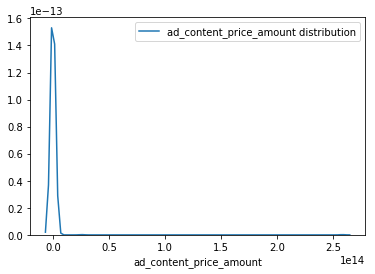

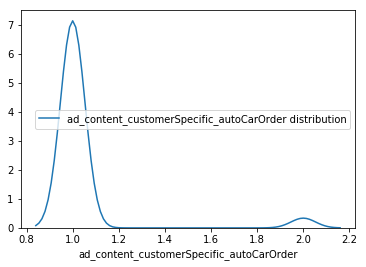

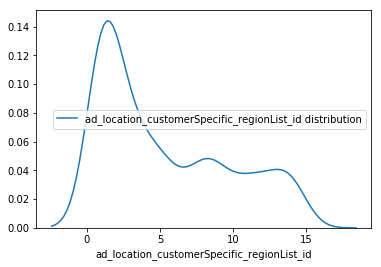

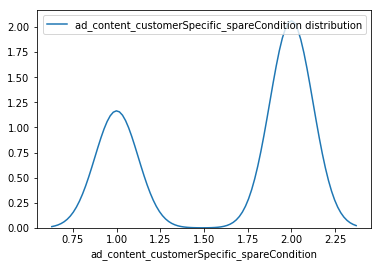

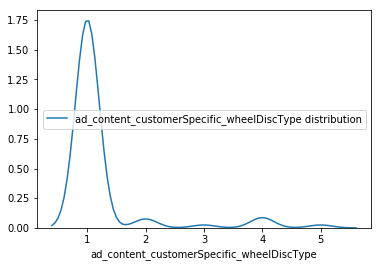

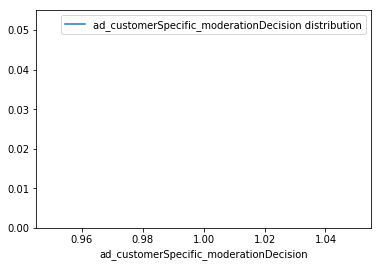

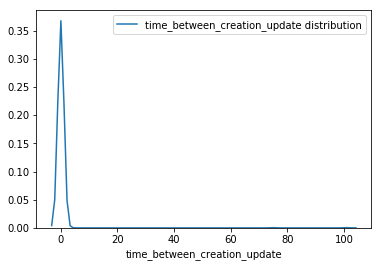

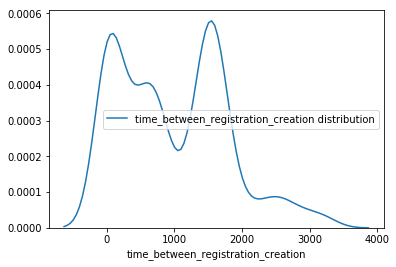

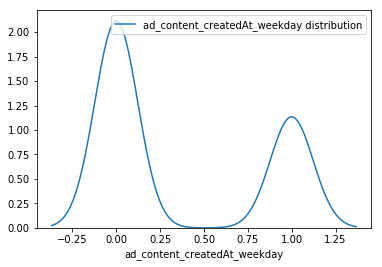

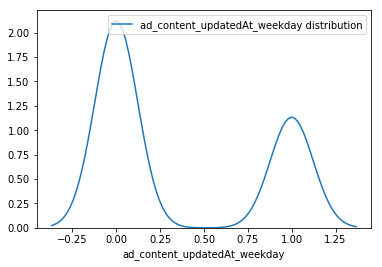

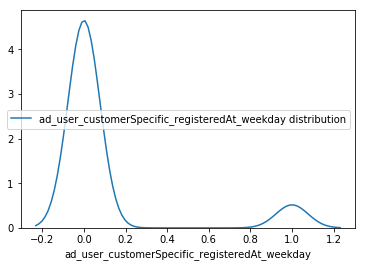

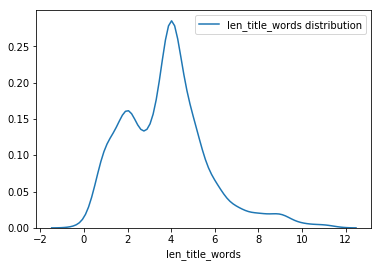

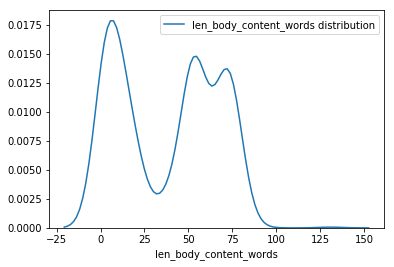

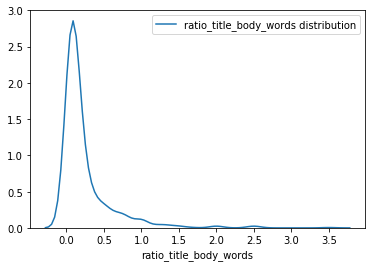

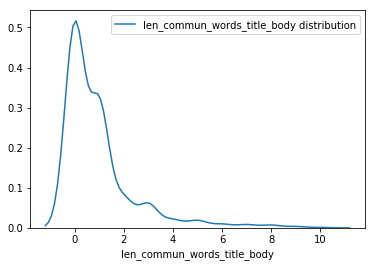

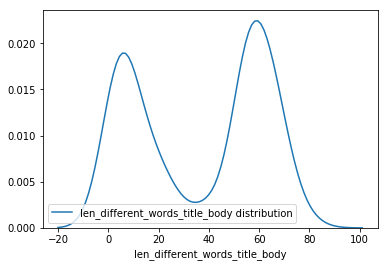

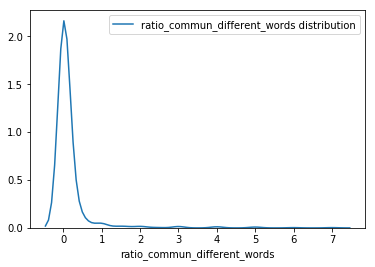

In [1159]:
## CLASS REJECTED
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==1][col], hist=False, label=col+" distribution")

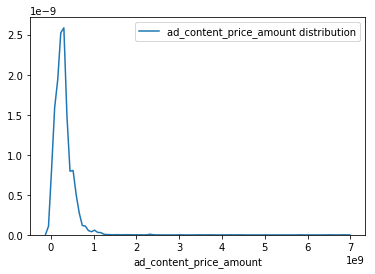

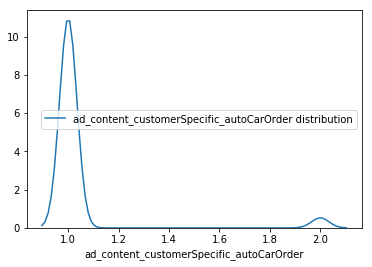

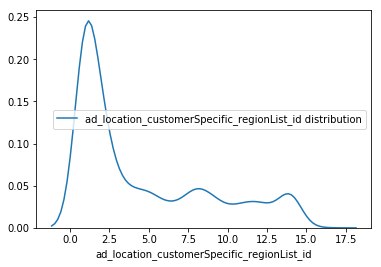

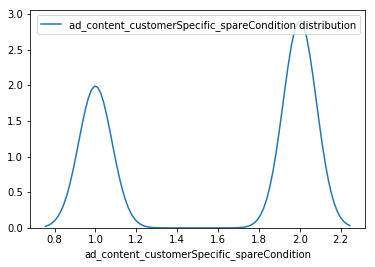

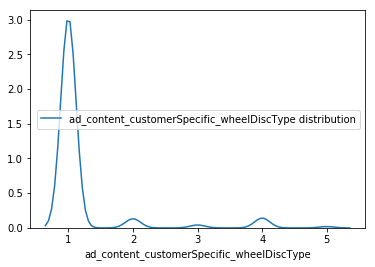

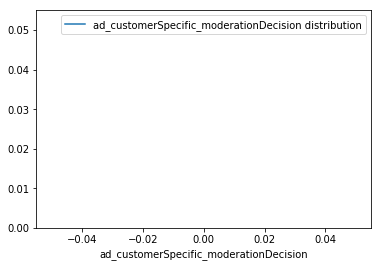

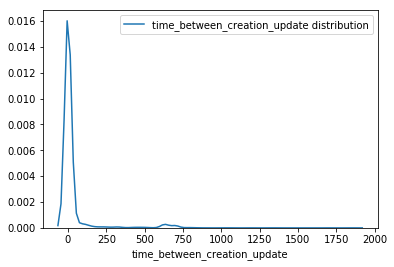

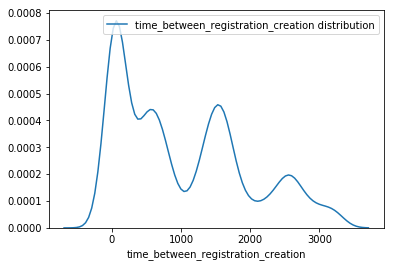

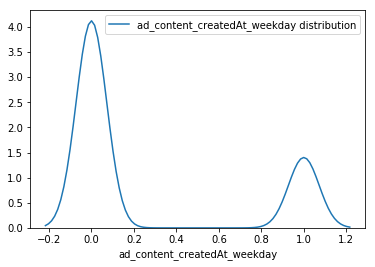

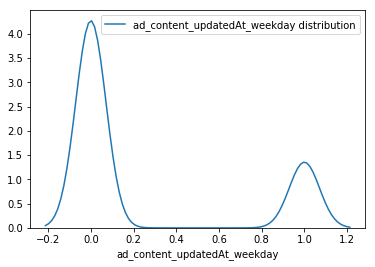

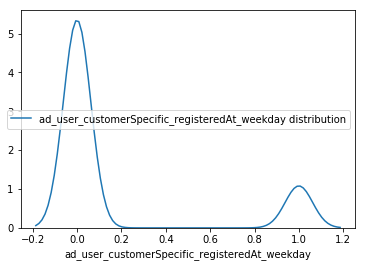

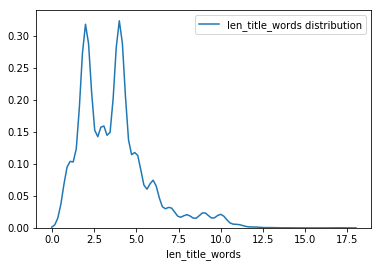

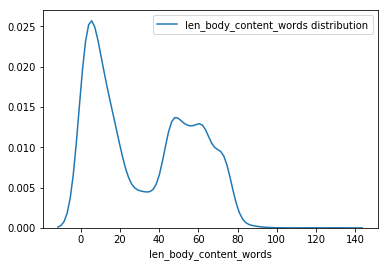

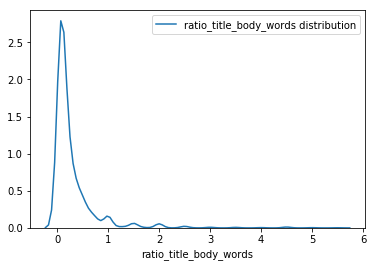

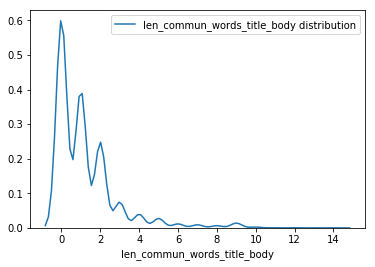

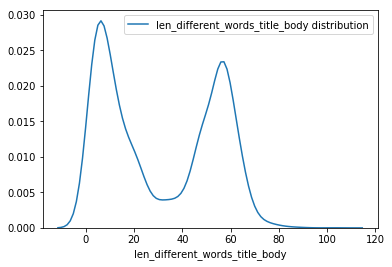

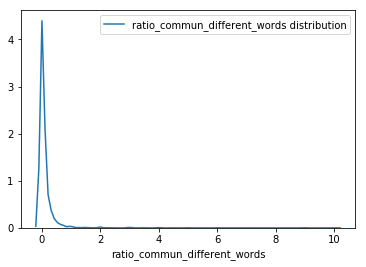

In [1160]:
## CLASS APPROVED 
numerical_columns = current_data.select_dtypes(exclude=['object']).columns
for i,col in enumerate(numerical_columns):
    plt.figure(i)
    sns.distplot(current_data[current_data[target_column]==0][col], hist=False, label=col+" distribution")

### B - DATA PREPATATION 

In [1078]:
columns_to_drop = ['ad_batchId', 'ad_taskId','ad_content_title', 'ad_content_body', 'len_commun_words_title_body']
current_data.drop(columns=columns_to_drop, inplace=True)
current_test_data.drop(columns=columns_to_drop, inplace=True)

In [1079]:
numerical_columns = current_data.select_dtypes(include=[np.number]).columns
categorical_columns = current_data.drop(columns=target_column).select_dtypes(exclude=[np.number]).columns

In [1080]:
## ENCODE CATEGORICAL VARIABLES 
current_data_features = current_data.drop(columns=target_column)
current_data_target = current_data[target_column]

current_data_features= pd.get_dummies(data=current_data_features, columns=categorical_columns)
current_test_data = pd.get_dummies(data=current_test_data, columns=categorical_columns)

current_data_features, current_test_data = current_data_features.align(current_test_data, join='left', axis=1)

## SPLIT DATA INTO TRAIN AND VALIDATION SETS 
X_train, X_val, y_train, y_val = train_test_split(current_data_features, current_data_target,
                                                    stratify=current_data_target, 
                                                    test_size=0.20)

In [1081]:
imb_weight = len(y_train[y_train==0])/len(y_train[y_train==1])
print(f"Classes are imbalanced with a ratio of {np.round(imb_weight*100, 2)}% of 0/1")

Classes are imbalanced with a ratio of 894.1% of 0/1


### C - BUILD CLASSIFICATION MODEL

In [1082]:
model = xgb.XGBClassifier(n_estimators=500, max_depth=7,
                          scale_pos_weight= math.sqrt(imb_weight)+1,
                          max_delta_step= 1.8, 
                         random_state=42, 
                         learning_rate=0.1,
                          min_child_weight = 10 ,n_jobs=4)

model.fit(X_train,y_train)

XGBClassifier(max_delta_step=1.8, max_depth=7, min_child_weight=10,
              n_estimators=500, n_jobs=4, random_state=42,
              scale_pos_weight=3.9901523767117717)

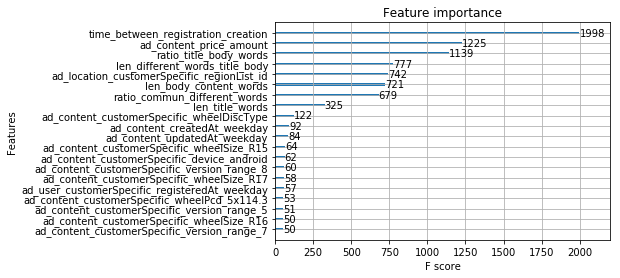

In [1083]:
plot_importance(model, max_num_features=20)

### D - MODEL VALIDATION 

In [1084]:
y_pred = model.predict_proba(X_val)

ROC AUC=0.895


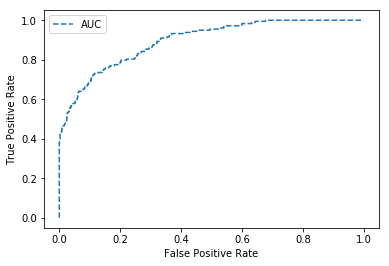

In [1085]:
# calculate scores
auc = roc_auc_score(y_val, y_pred[:, 1])

# summarize scores
print('ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_val, y_pred[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

In [1086]:
for thrs in np.arange(0.1, 0.9, 0.05):
    y_pred_cm = (y_pred[:,1] > thrs)*1
    print("threshold : ", round(thrs,2), ", F1 score : ", f1_score(y_val,y_pred_cm), ", % of predicted positifs : ", np.mean(y_pred_cm==1))
    print("Recall : ", recall_score(y_val, y_pred_cm), ", Precision : ", precision_score(y_val, y_pred_cm))
    print("#"*50)

threshold :  0.1 , F1 score :  0.44126984126984126 , % of predicted positifs :  0.25536723163841807
Recall :  0.7808988764044944 , Precision :  0.3075221238938053
##################################################
threshold :  0.15 , F1 score :  0.4863883847549909 , % of predicted positifs :  0.21073446327683615
Recall :  0.7528089887640449 , Precision :  0.35924932975871315
##################################################
threshold :  0.2 , F1 score :  0.5327695560253699 , % of predicted positifs :  0.16666666666666666
Recall :  0.7078651685393258 , Precision :  0.4271186440677966
##################################################
threshold :  0.25 , F1 score :  0.5396825396825397 , % of predicted positifs :  0.14858757062146893
Recall :  0.6685393258426966 , Precision :  0.4524714828897338
##################################################
threshold :  0.3 , F1 score :  0.5528846153846154 , % of predicted positifs :  0.1344632768361582
Recall :  0.6460674157303371 , Precision :  0.

[[1423  169]
 [  52  126]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      1592
           1       0.43      0.71      0.53       178

    accuracy                           0.88      1770
   macro avg       0.70      0.80      0.73      1770
weighted avg       0.91      0.88      0.89      1770



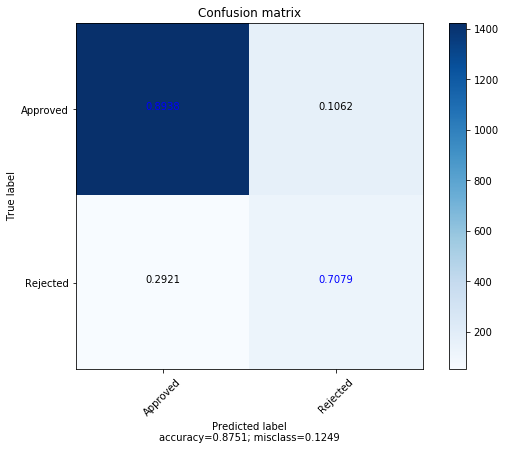

In [1087]:
thrs = 0.2
y_pred_cm = (y_pred[:, 1] > thrs)*1
print(confusion_matrix(y_val, y_pred_cm))

print(classification_report(y_val, y_pred_cm))

plot_confusion(confusion_matrix(y_val, y_pred_cm),
              ['Approved', 'Rejected'],
              title='Confusion matrix',
              cmap=None,
              normalize=True)

The recall of the positive class `rejected`is high, but the precision is still low. 
That means the class is well detected but the model also include points of other class in it.

### E - Model Predictions 


In [1088]:
y_test_pred = model.predict_proba(current_test_data)

y_test = (y_test_pred[:, 1] > thrs)*1
y_test = ["rejected" if x==1 else "approved" for x in y_test]

test_data_by_category[category][target_column] = y_test

In [1089]:
Counter(y_test)

Counter({'rejected': 509, 'approved': 1813})

# III - Concatenate test data

In [1092]:
test_original_index_order = test_data['ad_taskId']
test_original_index_order

0         99577563-d30e-4152-9c27-17d305b4eab6
1         c43c7d96-dfc3-435b-8a62-7df1a31aa64f
2         b87ff7e6-ddcb-4eb5-89e7-153da3240881
3         0022a545-4201-42d4-adb2-1f17023bf23c
4         866c0e28-55e2-4273-8ab3-1203dce8bfce
                          ...                 
100226    7765ef39-d0e9-4654-9a8e-aac98d4de359
100227    cc9c8f10-eec9-4f72-9ddc-691a9d360681
100228    2c3275b2-ec4d-49c7-b0b5-d8cb5e3ec153
100229    bdd8ee00-f74f-4139-8bdb-640b52e61128
100230    953ef58a-fd44-4697-8260-98d7451216a9
Name: ad_taskId, Length: 100231, dtype: object

In [1093]:
### ORDER `ad_taskId` 
ALL_TEST_DATA = pd.concat(test_data_by_category.values(), ignore_index=True)
ALL_TEST_DATA.set_index('ad_taskId', inplace=True)
ALL_TEST_DATA = ALL_TEST_DATA.reindex(index=test_original_index_order.values)

In [1095]:
ALL_TEST_DATA = ALL_TEST_DATA[['ad_batchId', target_column]]
ALL_TEST_DATA.reset_index(level=0, inplace=True)

In [1103]:
ALL_TEST_DATA.rename(columns={target_column:"prediction"}, inplace=True)

In [1105]:
ALL_TEST_DATA["prediction"].value_counts()

rejected    53110
approved    47121
Name: prediction, dtype: int64

In [1106]:
ALL_TEST_DATA.to_csv("test_predictions.csv")